In [2]:
apikey = "******"

In [ ]:
# !pip install nltk #installing nltk
# !pip install langdetect
# !pip install -U sentence-transformers

In [89]:
# Standard Libraries and Utilities
import json
import re
import time
import calendar
import ast
from datetime import datetime, timedelta
from string import punctuation
from pprint import pprint
from collections import Counter

# Data Handling and Analysis
import numpy as np
import pandas as pd

# Natural Language Processing (NLP)
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords, wordnet, words
from nltk.stem import WordNetLemmatizer, PorterStemmer, SnowballStemmer
from nltk.util import ngrams
import spacy
import gensim
from langdetect import detect

# Machine Learning and Text Processing
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD, PCA
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from scipy.sparse import csr_matrix
from sentence_transformers import SentenceTransformer, util

# Visualization Libraries
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
%matplotlib inline

# Network and Error Handling
import urllib.request
from urllib.error import HTTPError


In [ ]:
nltk.download('all')

##API request

In [ ]:

# Function to safely make a request with exponential backoff
def safe_request(url, max_attempts=5):
    attempt = 0
    while attempt < max_attempts:
        try:
            with urllib.request.urlopen(url) as response:
                data = json.loads(response.read().decode("utf-8"))
                return data
        except HTTPError as e:
            if e.code == 429:  # Too Many Requests
                sleep_time = 2 ** attempt  # Exponential backoff formula
                time.sleep(sleep_time)
                attempt += 1
            else:
                raise  # Reraise for other HTTP errors
    raise Exception(f"Failed to fetch data after {max_attempts} attempts")

# Function to fetch data for a specific date
def fetch_data(date, apikey, max_articles=100):
    url = f"https://gnews.io/api/v4/search?q=israel&lang=en&country=us&max={max_articles}&to={date}T23:59:59Z&apikey={apikey}"
    data = safe_request(url)
    return data["articles"]

# Initialize parameters
start_date = datetime(2023, 10, 5)  # Start date (year, month, day)
end_date = datetime(2024, 3, 11)    # End date (year, month, day)

all_articles = []
current_date = start_date
requests_made = 0
requests_per_second_limit = 8  # Max requests per second
total_requests_limit = 25000  # Max total requests per day

# Loop through each day and fetch data, respecting the request limits
while current_date <= end_date and requests_made < total_requests_limit:
    articles_for_day = fetch_data(current_date.strftime('%Y-%m-%d'), apikey)
    all_articles.extend(articles_for_day)
    current_date += timedelta(days=1)
    requests_made += 1

    # Implement a pause if the number of requests reaches the per-second limit
    if requests_made % requests_per_second_limit == 0:
        time.sleep(1)  # Pause for 1 second to stay within the rate limit

# Convert to DataFrame
dfgnews = pd.DataFrame(all_articles)

This code is designed to retrieve a collection of news articles related to "Israel" from the GNews API over a specified date range.Since the October 7 attack by Hamas and the beginning of the war. It uses two functions: `safe_request` for making web requests with retries on failure, and `fetch_data` to fetch news articles for a given date.

The process respects rate limits by using an exponential backoff strategy when too many requests are made in rapid succession, and by pausing when the per-second request limit is reached. The articles fetched each day are added to a list, and once the data collection is complete, the list is converted into a Pandas DataFrame.

The code ensures that data fetching adheres to the API's usage constraints, such as the maximum number of requests per second and total requests per day. It aims to create a structured dataset of news articles for further analysis or processing.

In [7]:
import warnings

warnings.filterwarnings('ignore')

In [8]:


url = 'https://raw.githubusercontent.com/aviya-gmara/News-Classification-Project-/main/dfgnews_test%20(1).csv'


dfgnews = pd.read_csv(url)

## Review the data

In [9]:
dfgnews.head()



Unnamed: 0                                              title  \
0          99  Biden Aides and Saudis Explore Defense Treaty ...   
1          98  Opinion: The Netanyahu government’s next targe...   
2          97  At least 6 Palestinians killed in latest fight...   
3          96  Dana-Farber threatens the market dominance of ...   
4          94  Six Palestinians are killed in latest fighting...   

                                         description  \
0  Despite U.S. fatigue over Middle East wars, th...   
1  President Joe Biden must make it clear to Isra...   
2  Israeli military operations in the occupied We...   
3  Dana-Farber’s plan to move its inpatient oncol...   
4  Palestinian health officials say the death tol...   

                                             content  \
0  American and Saudi officials are discussing te...   
1  Editor’s note: Dan Perry is the former Cairo-b...   
2  Israeli military operations in the occupied We...   
3  “We were thunderstruck. We knew they had initi...   
4  The death toll from the most recent flare-up s...   

                                                 url  \
0  https://www.nytimes.com/2023/09/19/us/politics...   
1  https://edition.cnn.com/2023/09/19/opinions/ne...   
2  https://www.nbcboston.com/news/national-intern...   
3  https://www.bostonglobe.com/2023/09/20/opinion...   
4  https://www.bostonglobe.com/2023/09/20/world/l...   

                                               image           publishedAt  \
0  https://static01.nyt.com/images/2023/09/19/mul...  2023-09-19T16:29:53Z   
1  https://media.cnn.com/api/v1/images/stellar/pr...  2023-09-19T22:26:25Z   
2  https://media.nbcboston.com/2023/09/AP23262602...  2023-09-20T03:09:46Z   
3  https://bostonglobe-prod.cdn.arcpublishing.com...  2023-09-20T04:00:00Z   
4  https://bostonglobe-prod.cdn.arcpublishing.com...  2023-09-20T04:00:00Z   

                                              source  
0  {'name': 'The New York Times', 'url': 'https:/...  
1  {'name': 'Cable News Network', 'url': 'https:/...  
2  {'name': 'NBC10 Boston', 'url': 'https://www.n...  
3  {'name': 'The Boston Globe', 'url': 'https://w...  
4  {'name': 'The Boston Globe', 'url': 'https://w...


`title`: The title of the news article.


`description`: A brief summary or the leading paragraph of the article.The small paragraph under the title.


`content`: The full text or the main body of the news article.

`url`: The URL where the article can be found.

`image`: A URL link to an image associated with the article.

`publishedAt`: The publication date and time of the article, in ISO 8601 format.

`source`: A dictionary or string representation of a dictionary containing the 'name' of the publication and its 'url'

In [10]:
dfgnews.shape

(15900, 8)

In [11]:
#check for null values
dfgnews.isnull().sum()

Unnamed: 0     0
title          0
description    0
content        0
url            0
image          0
publishedAt    0
source         0
dtype: int64

### Creating an easy-to-read structure of the content of each article


In [12]:

# for i in range(len(dfgnews)):
#     print(f"Title: {dfgnews['title'][i]}")
#     print(f"description: {dfgnews['description'][i]}")
#     print(f"Content: {dfgnews['content'][i]}")
#     print(f"publishedAt: {dfgnews['publishedAt'][i]}")
#     print("*********")



In [13]:
#Removing all the articles that are from before the attack
dfgnews = dfgnews[dfgnews['publishedAt'] >= '2023-10-06']


In [14]:
#Unnecessary columns
dfgnews = dfgnews.loc[:, ~dfgnews.columns.isin(['image', 'source','Unnamed: 0'])]


In [15]:
# dfgnews.duplicated(subset=['title', 'description',"url"]).sum()


In [16]:

dfgnews = dfgnews.drop_duplicates(subset=['title', 'description',"url"])


In [17]:
#create new column for the character length of each content and description article
#drop unnecessary columns

dfgnews['len_content_article'] = dfgnews.content.str.len()
dfgnews['len_description_article'] = dfgnews.description.str.len()


dfgnews

title  \
208    A San Fernando Valley athlete will be represen...   
210    Palestinian gunmen reported in Israel as barra...   
212     Conflict between Israel and Palestinians in Gaza   
214                               On This Day in History   
216    US tourist arrested for smashing Roman statues...   
...                                                  ...   
15895  Is Iran Warming Up to a 'Second Israel' Across...   
15896     Israel threatens the identity of American Jews   
15897  Bands pull out of SXSW over U.S. Army sponsors...   
15898  UN's Colonna in Israel on first UNRWA-Hamas pr...   
15899  Biden should draw red lines for Hamas - not Is...   

                                             description  \
208    Israel Mateos says frontball isn't typically p...   
210    Palestinian gunmen reported in Israel as barra...   
212     Conflict between Israel and Palestinians in Gaza   
214    On Oct. 6, 1973, Egypt and Syria launched a co...   
216    Israeli police have arrested an American touri...   
...                                                  ...   
15895  Iran's foreign minister declared "a new chapte...   
15896  In short, for many American Jews, Israel is a ...   
15897  Multiple bands and musicians scheduled to perf...   
15898  Catherine Colonna, the former French foreign m...   
15899  President Biden on Saturday suggested he might...   

                                                 content  \
208    Israel Mateos is representing Team USA at this...   
210    Published Oct 07, 2023 12:49AM ET Updated Oct ...   
212    Published Oct 07, 2023 04:09AM ET\n© Reuters. ...   
214    1 of 4 | Israeli soldiers lay flowers at a war...   
216    Israeli police have arrested an American touri...   
...                                                  ...   
15895  As Iran becomes more deeply mired in the crise...   
15896  My father was something of a lapsed Jew. An ar...   
15897  Multiple bands and musicians scheduled to perf...   
15898  March 11, 2024\nFormer French Foreign Minister...   
15899  President Biden on Saturday suggested he might...   

                                                     url  \
208    https://abc7.com/israel-mateos-frontball-pan-a...   
210    https://www.investing.com/news/world-news/rock...   
212    https://www.investing.com/news/world-news/conf...   
214    https://www.upi.com/Top_News/2023/10/06/UPI-Al...   
216    https://www.nbcboston.com/news/national-intern...   
...                                                  ...   
15895  https://www.newsweek.com/iran-azerbaijan-ties-...   
15896  https://thehill.com/opinion/4523878-israel-thr...   
15897  https://thehill.com/blogs/in-the-know/4524332-...   
15898  https://www.al-monitor.com/originals/2024/03/u...   
15899  https://nypost.com/2024/03/11/opinion/biden-sh...   

                publishedAt  len_content_article  len_description_article  
208    2023-10-06T00:11:11Z                  266                       97  
210    2023-10-06T04:00:00Z                  266                       68  
212    2023-10-06T04:00:00Z                  266                       48  
214    2023-10-06T07:00:07Z                  266                      175  
216    2023-10-06T08:31:41Z                  266                      162  
...                     ...                  ...                      ...  
15895  2024-03-11T17:10:02Z                  267                      146  
15896  2024-03-11T17:30:00Z                  266                      224  
15897  2024-03-11T18:35:40Z                  266                      347  
15898  2024-03-11T18:52:41Z                  266                      270  
15899  2024-03-11T19:33:44Z                  266                      197  

[7004 rows x 7 columns]

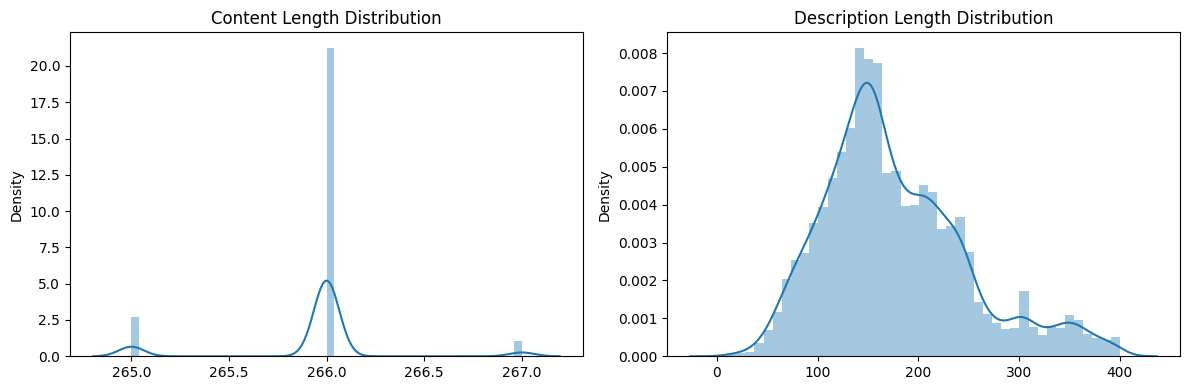

In [18]:


# Create two separate DataFrames for content and description lengths
df_content_len = dfgnews[['len_content_article']]
df_description_len = dfgnews[['len_description_article']]

# Create two separate distribution plots
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.distplot(df_content_len, ax=axes[0])
axes[0].set_title('Content Length Distribution')

sns.distplot(df_description_len, ax=axes[1])
axes[1].set_title('Description Length Distribution')

plt.tight_layout()
plt.show()


In [19]:
print('mean len_content:', dfgnews.len_content_article.mean())
print('std len_content:', dfgnews.len_content_article.std())
print('max len_content:', dfgnews.len_content_article.max())
print('min len_content:', dfgnews.len_content_article.min())
print("*****")
print('mean len_description:', dfgnews.len_description_article.mean())
print('std len_description:', dfgnews.len_description_article.std())
print('max len_description:', dfgnews.len_description_article.max())
print('min len_description:', dfgnews.len_description_article.min())

mean len_content: 265.93560822387207
std len_content: 0.38163602158664733
max len_content: 267
min len_content: 265
*****
mean len_description: 176.62692747001714
std len_description: 71.52155735159371
max len_description: 400
min len_description: 10


### The `content` column is usually of uniform length because the API only returns a fixed amount of characters, on the other hand the `description` is very variable and can provide more or less information.
### Both features can be used.

In [20]:


# Create a dictionary to store the count of articles for each month and year
month_year_counts = {}
dfgnews['publishedAt'] = pd.to_datetime(dfgnews['publishedAt'])

# Iterate through each row in the DataFrame
for index, row in dfgnews.iterrows():
    # Extract the month and year from the publishedAt column
    month = row["publishedAt"].month
    year = row["publishedAt"].year

    # Create a key for the dictionary using the month and year
    key = (calendar.month_abbr[month], year)

    # If the key is not in the dictionary, initialize it with a count of 0
    if key not in month_year_counts:
        month_year_counts[key] = 0

    # Increment the count for the key
    month_year_counts[key] += 1

# Print the count of articles for each month and year
for key, count in month_year_counts.items():
    print(f"{key[0]} {key[1]}: {count}")


Oct 2023: 2238
Nov 2023: 2002
Dec 2023: 876
Jan 2024: 624
Feb 2024: 970
Mar 2024: 294


In [21]:

# Create a dictionary to store the count of articles for each month
month_counts = {}

# Iterate through each row in the DataFrame
for index, row in dfgnews.iterrows():
    # Extract the month from the publishedAt column
    month = row["publishedAt"].month

    # If the month is not in the dictionary, initialize it with a count of 0
    if month not in month_counts:
        month_counts[month] = 0

    # Increment the count for the month
    month_counts[month] += 1

# Calculate the number of days in each month
days_in_month = {}
for month in month_counts:
    days_in_month[month] = calendar.monthrange(2023, month)[1]

# Calculate the average number of articles per day for each month
average_articles_per_day = {}
for month, count in month_counts.items():
    average_articles_per_day[month] = count / days_in_month[month]

# Print the average number of articles per day for each month
for month, average in average_articles_per_day.items():
    print(f"{calendar.month_abbr[month]}: {average:.2f}")


Oct: 72.19
Nov: 66.73
Dec: 28.26
Jan: 20.13
Feb: 34.64
Mar: 9.48


## It seems that most of the articles were at the beginning of the war and over time the news coverage decreases



---
# Decision node - which feature to use?
## **description** or **description**?

In [22]:
feature_for_training='description' #  description or content

This column was created to receive a maximum of 250 characters when others use the `content` column. We saw that we are ready to create one thing for this column.
Since the `description` is of variable length and is most likely shorter than `content` and most every word has a meaning, we chose not to shorten it unnecessarily but to create the match if you choose another feature.

In [23]:
def remove_suffix(text):
    return re.sub(r"\[\d+ chars\]$", "", text)

# Apply the function to the 'content' column
dfgnews[feature_for_training] = dfgnews[feature_for_training].apply(remove_suffix)

#create column for first 250 words
dfgnews['split_words'] = dfgnews[feature_for_training].str.split()
dfgnews['first_250_words'] = dfgnews['split_words'].apply(lambda x: x[:250])

#rejoin the words in first 100
dfgnews['first_250_words'] = dfgnews['first_250_words'].apply(lambda x: ' '.join(x))

#drop unnecessary columns
dfgnews = dfgnews.drop(['split_words'], axis = 1)
dfgnews

title  \
208    A San Fernando Valley athlete will be represen...   
210    Palestinian gunmen reported in Israel as barra...   
212     Conflict between Israel and Palestinians in Gaza   
214                               On This Day in History   
216    US tourist arrested for smashing Roman statues...   
...                                                  ...   
15895  Is Iran Warming Up to a 'Second Israel' Across...   
15896     Israel threatens the identity of American Jews   
15897  Bands pull out of SXSW over U.S. Army sponsors...   
15898  UN's Colonna in Israel on first UNRWA-Hamas pr...   
15899  Biden should draw red lines for Hamas - not Is...   

                                             description  \
208    Israel Mateos says frontball isn't typically p...   
210    Palestinian gunmen reported in Israel as barra...   
212     Conflict between Israel and Palestinians in Gaza   
214    On Oct. 6, 1973, Egypt and Syria launched a co...   
216    Israeli police have arrested an American touri...   
...                                                  ...   
15895  Iran's foreign minister declared "a new chapte...   
15896  In short, for many American Jews, Israel is a ...   
15897  Multiple bands and musicians scheduled to perf...   
15898  Catherine Colonna, the former French foreign m...   
15899  President Biden on Saturday suggested he might...   

                                                 content  \
208    Israel Mateos is representing Team USA at this...   
210    Published Oct 07, 2023 12:49AM ET Updated Oct ...   
212    Published Oct 07, 2023 04:09AM ET\n© Reuters. ...   
214    1 of 4 | Israeli soldiers lay flowers at a war...   
216    Israeli police have arrested an American touri...   
...                                                  ...   
15895  As Iran becomes more deeply mired in the crise...   
15896  My father was something of a lapsed Jew. An ar...   
15897  Multiple bands and musicians scheduled to perf...   
15898  March 11, 2024\nFormer French Foreign Minister...   
15899  President Biden on Saturday suggested he might...   

                                                     url  \
208    https://abc7.com/israel-mateos-frontball-pan-a...   
210    https://www.investing.com/news/world-news/rock...   
212    https://www.investing.com/news/world-news/conf...   
214    https://www.upi.com/Top_News/2023/10/06/UPI-Al...   
216    https://www.nbcboston.com/news/national-intern...   
...                                                  ...   
15895  https://www.newsweek.com/iran-azerbaijan-ties-...   
15896  https://thehill.com/opinion/4523878-israel-thr...   
15897  https://thehill.com/blogs/in-the-know/4524332-...   
15898  https://www.al-monitor.com/originals/2024/03/u...   
15899  https://nypost.com/2024/03/11/opinion/biden-sh...   

                    publishedAt  len_content_article  len_description_article  \
208   2023-10-06 00:11:11+00:00                  266                       97   
210   2023-10-06 04:00:00+00:00                  266                       68   
212   2023-10-06 04:00:00+00:00                  266                       48   
214   2023-10-06 07:00:07+00:00                  266                      175   
216   2023-10-06 08:31:41+00:00                  266                      162   
...                         ...                  ...                      ...   
15895 2024-03-11 17:10:02+00:00                  267                      146   
15896 2024-03-11 17:30:00+00:00                  266                      224   
15897 2024-03-11 18:35:40+00:00                  266                      347   
15898 2024-03-11 18:52:41+00:00                  266                      270   
15899 2024-03-11 19:33:44+00:00                  266                      197   

                                         first_250_words  
208    Israel Mateos says frontball isn't typically p...  
210    Palestinian gunmen reported in Israel as barra...  
212     Conflict 

## Tokenize and Remove Stop Words

In [25]:



dfgnews['first_250_words'] = dfgnews['first_250_words'].astype(str)

dfgnews.first_250_words = dfgnews.first_250_words.str.lower()


In [26]:
# Define the function to clean the news title column
def cleaned_desc_column(text):
  # Remove commas
  text = re.sub(r',', '', text)
  # Remove extra spaces
  text = re.sub(r'\s+', ' ', text)
  # Remove full stops
  text = re.sub(r'\.', '', text)
  # Remove single quotes and double quotes
  text = re.sub(r"['\"]", '', text)
  # Remove other non-word characters
  text = re.sub(r'\W', ' ', text)

  text_token = word_tokenize(text)
  stop_words = set(stopwords.words('english'))

  filtered_text = []

  for sw in text_token:
    if sw not in stop_words:
        filtered_text.append(sw)

  # text = " ".join(filtered_text)
  return filtered_text

dfgnews['sent_word_tokenized_first_250_no_stops'] = dfgnews['first_250_words'].apply(cleaned_desc_column)


# Lemmatization and Stemming

In [27]:
stemmer = PorterStemmer()


In [28]:
# Create function to stem each word in a list and concatenate the list into a string
def stem_list(lst):
    stemmed_list = [stemmer.stem(i) for i in lst]
    stem_string = ' '.join(stemmed_list)
    return stem_string

# Apply the stem_list function directly on each list in the 'lemmatized_tokens' column
dfgnews['stemmed'] = dfgnews["sent_word_tokenized_first_250_no_stops"].apply(stem_list)

In [29]:
from nltk.corpus import wordnet

def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None


In [30]:
def lemmatize_tokens(text):
    # Tokenize the text if it is a string
    if isinstance(text, str):
        token_list = word_tokenize(text)
    else:
        token_list = text  # Assume it's already a list of tokens if not a string

    lemmatizer = WordNetLemmatizer()
    nltk_tagged = nltk.pos_tag(token_list)
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            # if there is no available tag, append the token as is
            lemmatized_sentence.append(word)
        else:
            # else use the tag to lemmatize the token
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))

    # Convert the list to a string after processing all words
    lemmatized_sentence = ' '.join(lemmatized_sentence)
    return lemmatized_sentence

# Now you can apply the function to the 'stemmed' column
# Ensure that 'dfgnews' DataFrame and the 'stemmed' column are properly defined before this step
dfgnews['lemmatized_text'] = dfgnews['stemmed'].apply(lemmatize_tokens)

In [31]:
dfgnews.head()

title  \
208  A San Fernando Valley athlete will be represen...   
210  Palestinian gunmen reported in Israel as barra...   
212   Conflict between Israel and Palestinians in Gaza   
214                             On This Day in History   
216  US tourist arrested for smashing Roman statues...   

                                           description  \
208  Israel Mateos says frontball isn't typically p...   
210  Palestinian gunmen reported in Israel as barra...   
212   Conflict between Israel and Palestinians in Gaza   
214  On Oct. 6, 1973, Egypt and Syria launched a co...   
216  Israeli police have arrested an American touri...   

                                               content  \
208  Israel Mateos is representing Team USA at this...   
210  Published Oct 07, 2023 12:49AM ET Updated Oct ...   
212  Published Oct 07, 2023 04:09AM ET\n© Reuters. ...   
214  1 of 4 | Israeli soldiers lay flowers at a war...   
216  Israeli police have arrested an American touri...   

                                                   url  \
208  https://abc7.com/israel-mateos-frontball-pan-a...   
210  https://www.investing.com/news/world-news/rock...   
212  https://www.investing.com/news/world-news/conf...   
214  https://www.upi.com/Top_News/2023/10/06/UPI-Al...   
216  https://www.nbcboston.com/news/national-intern...   

                  publishedAt  len_content_article  len_description_article  \
208 2023-10-06 00:11:11+00:00                  266                       97   
210 2023-10-06 04:00:00+00:00                  266                       68   
212 2023-10-06 04:00:00+00:00                  266                       48   
214 2023-10-06 07:00:07+00:00                  266                      175   
216 2023-10-06 08:31:41+00:00                  266                      162   

                                       first_250_words  \
208  israel mateos says frontball isn't typically p...   
210  palestinian gunmen reported in israel as barra...   
212   conflict between israel and palestinians in gaza   
214  on oct. 6, 1973, egypt and syria launched a co...   
216  israeli police have arrested an american touri...   

                sent_word_tokenized_first_250_no_stops  \
208  [israel, mateos, says, frontball, isnt, typica...   
210  [palestinian, gunmen, reported, israel, barrag...   
212             [conflict, israel, palestinians, gaza]   
214  [oct, 6, 1973, egypt, syria, launched, coordin...   
216  [israeli, police, arrested, american, tourist,...   

                                               stemmed  \
208  israel mateo say frontbal isnt typic play us p...   
210  palestinian gunmen report israel barrag launch...   
212                   conflict israel palestinian gaza   
214  oct 6 1973 egypt syria launch coordin attack i...   
216  isra polic arrest american tourist israel muse...   

                                       lemmatized_text  
208  israel mateo say frontbal isnt typic play us p...  
210  palestinian gunman report israel barrag launch...  
212                   conflict israel palestinian gaza  
214  oct 6 1973 egypt syria launch coordin attack i...  
216  isra polic arrest american tourist israel muse...

###*Stemming:*

**seen** changed to **see**: The "n" ending seems to have been removed, as expected from a stemming process.

**taken** changed to **take**: Here too, the "n" ending was removed, which aligns with the stemming process.

**rights** changed to **right**: The plural "s" suffix was removed, indicating stemming.

**companies** changed to **company**: The process seems to have removed the "ies" suffix and left the word in its stem form.

**britains** changed to **britain**: The "s" ending, possibly indicating a plural or possessive form, was removed.

####*Lemmatization:*

**reuters** changed to **reuter**: The "s" suffix seems to have been removed, as expected from a stemming process.

**belonging** changed to **belong**: Here too, the "ing" suffix was removed, which aligns with the stemming process.

**migrants** changed to **migrant**: The plural "s" suffix was removed, indicating stemming.

**authorities** changed to **author**: The process seems to have removed the "ities" suffix and left the word in its stem form.

**dinghy** changed to **dinghi**: This is a less typical change for stemming, but it's possible the algorithm removed the "y" in an attempt to reach the stem of the word.

###We will move on to cleaning steps that are more suitable for our data:
1. Removing words that repeat themselves frequently or are unnecessary
2.Creating phrases to join them into one phrase due to the tendency to use phrases in news articles

---





In [32]:
clean_dfgnews = dfgnews.copy()


In [33]:
clean_dfgnews.head()

title  \
208  A San Fernando Valley athlete will be represen...   
210  Palestinian gunmen reported in Israel as barra...   
212   Conflict between Israel and Palestinians in Gaza   
214                             On This Day in History   
216  US tourist arrested for smashing Roman statues...   

                                           description  \
208  Israel Mateos says frontball isn't typically p...   
210  Palestinian gunmen reported in Israel as barra...   
212   Conflict between Israel and Palestinians in Gaza   
214  On Oct. 6, 1973, Egypt and Syria launched a co...   
216  Israeli police have arrested an American touri...   

                                               content  \
208  Israel Mateos is representing Team USA at this...   
210  Published Oct 07, 2023 12:49AM ET Updated Oct ...   
212  Published Oct 07, 2023 04:09AM ET\n© Reuters. ...   
214  1 of 4 | Israeli soldiers lay flowers at a war...   
216  Israeli police have arrested an American touri...   

                                                   url  \
208  https://abc7.com/israel-mateos-frontball-pan-a...   
210  https://www.investing.com/news/world-news/rock...   
212  https://www.investing.com/news/world-news/conf...   
214  https://www.upi.com/Top_News/2023/10/06/UPI-Al...   
216  https://www.nbcboston.com/news/national-intern...   

                  publishedAt  len_content_article  len_description_article  \
208 2023-10-06 00:11:11+00:00                  266                       97   
210 2023-10-06 04:00:00+00:00                  266                       68   
212 2023-10-06 04:00:00+00:00                  266                       48   
214 2023-10-06 07:00:07+00:00                  266                      175   
216 2023-10-06 08:31:41+00:00                  266                      162   

                                       first_250_words  \
208  israel mateos says frontball isn't typically p...   
210  palestinian gunmen reported in israel as barra...   
212   conflict between israel and palestinians in gaza   
214  on oct. 6, 1973, egypt and syria launched a co...   
216  israeli police have arrested an american touri...   

                sent_word_tokenized_first_250_no_stops  \
208  [israel, mateos, says, frontball, isnt, typica...   
210  [palestinian, gunmen, reported, israel, barrag...   
212             [conflict, israel, palestinians, gaza]   
214  [oct, 6, 1973, egypt, syria, launched, coordin...   
216  [israeli, police, arrested, american, tourist,...   

                                               stemmed  \
208  israel mateo say frontbal isnt typic play us p...   
210  palestinian gunmen report israel barrag launch...   
212                   conflict israel palestinian gaza   
214  oct 6 1973 egypt syria launch coordin attack i...   
216  isra polic arrest american tourist israel muse...   

                                       lemmatized_text  
208  israel mateo say frontbal isnt typic play us p...  
210  palestinian gunman report israel barrag launch...  
212                   conflict israel palestinian gaza  
214  oct 6 1973 egypt syria launch coordin attack i...  
216  isra polic arrest american tourist israel muse...

### Removing **stop words** that match our data

In [34]:

clean_dfgnews['lemmatized_text'] = clean_dfgnews['lemmatized_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in ['israel', 'isra','say','hama','gaza','strip','ukrain','war','us','2023',"monday", "tuesday", "wednesday", "thursday", "friday", "saturday", "sunday"]]))


In [36]:




def remove_publish_to_reuter(text):
    # Regular expression that looks for a character sequence that starts with 'publish', goes through any character (including new lines) and ends with 'reuter'
    # The '.*?' ensures a non-greedy match, capturing the shortest possible content that fits the pattern
    pattern = r'publish.*?reuter'

    # Replace the matched text with an empty string
    cleaned_text = re.sub(pattern, '', text, flags=re.IGNORECASE | re.DOTALL)

    return cleaned_text

# Apply the function to the 'lemmatized_text' column
clean_dfgnews['lemmatized_text'] = clean_dfgnews['lemmatized_text'].apply(remove_publish_to_reuter)



### Creating common word combinations in the news to reduce noise of words that are actually word combinations

In [37]:

def transform_words(text):
    # Initial replacements to standardize 'octob' and 'oct' to 'october'
    text = re.sub(r'\boctob\b', 'october', text, flags=re.IGNORECASE)
    text = re.sub(r'\boct\b', 'october', text, flags=re.IGNORECASE)

    # Specific replacement for '7 october' to 'october_7'
    text = re.sub(r'\boctober\s*7\b', 'october_7', text, flags=re.IGNORECASE)

    # The rest of the replacements we discussed
    replacements = {
        r'\bprime minister\b': 'minister_netanyahu',
        r'\bdefends forc\b': 'defenses_force',
        r'\bwhite hous\b': 'white_house',
        r'\bmiddl east\b': 'middl_east',
        r'\bunit nation\b': 'united_nation',
        r'\btel aviv\b': 'tel_aviv',
        r'\bnew york\b': 'new_york',
        r'\bbenjamin netanyahu\b': 'minister_netanyahu',
        r'\b(presid joe|joe biden|presid biden|presid joe biden|presid|biden)\b': 'joe_biden',
        r'\bunit state\b': 'unit_state',
        r'\bhumanitarian aid\b': 'humanitarian_aid',
        r'\byear old\b': 'year_old',
        r'\bsocial medium\b': 'social_medium',
        r'\bantoni blinken\b': 'antoni_blinken',
        r'\bwest bank\b': 'west_bank',
        r'\bhostag hold\b': 'hostag_hold',
        r'\bpro palestinian\b': 'pro_palestinian',
        r'\breleas hostag\b': 'releas_hostag',
        r'\bterrorist attack\b': 'terrorist_attack',
        r'\bnbc news\b': 'nbc_news',
        # Add more replacements as needed
    }

    # Perform all the replacements from the dictionary
    for pattern, replacement in replacements.items():
        text = re.sub(pattern, replacement, text, flags=re.IGNORECASE)

    return text

# Apply the function to the 'lemmatized_text' column
clean_dfgnews['clean_text_feature'] = clean_dfgnews['lemmatized_text'].apply(transform_words)


### Creating three options for training based on text:


### 1.   Main- Text that has undergone all stages of cleaning and will be broken down into individual words: `clean_text_feature`
### 2.   Text that has been cleaned and will be split into combinations of two words: `Bigrams`
### 3. Based on the `description` column


In [38]:

clean_dfgnews_clean_text_feature = clean_dfgnews[['clean_text_feature']]
clean_dfgnews_clean_text_feature


clean_text_feature
208            mateo frontbal isnt typic play plan chang
210              palestinian gunman report barrag launch
212                                 conflict palestinian
214    october 6 1973 egypt syria launch coordin atta...
216    polic arrest american tourist museum jerusalem...
...                                                  ...
15895  iran foreign minist declar new chapter relat t...
15896  short mani american jew test test deepli hold ...
15897  multipl band musician schedul perform south so...
15898  catherin colonna former french foreign minist ...
15899  joe_biden suggest might cut militari assist mo...

[7004 rows x 1 columns]

In [39]:
from nltk.util import ngrams
import nltk

def generate_ngrams_from_text(text, n=2):
    tokens = nltk.word_tokenize(text)
    n_grams = ['_'.join(grams) for grams in ngrams(tokens, n)]
    return ' '.join(n_grams)

clean_dfgnews['Bigrams'] = clean_dfgnews['clean_text_feature'].apply(lambda x: generate_ngrams_from_text(x, n=2))
clean_dfgnews_Bigrams = clean_dfgnews[['Bigrams']]
clean_dfgnews_Bigrams


Bigrams
208    mateo_frontbal frontbal_isnt isnt_typic typic_...
210    palestinian_gunman gunman_report report_barrag...
212                                 conflict_palestinian
214    october_6 6_1973 1973_egypt egypt_syria syria_...
216    polic_arrest arrest_american american_tourist ...
...                                                  ...
15895  iran_foreign foreign_minist minist_declar decl...
15896  short_mani mani_american american_jew jew_test...
15897  multipl_band band_musician musician_schedul sc...
15898  catherin_colonna colonna_former former_french ...
15899  joe_biden_suggest suggest_might might_cut cut_...

[7004 rows x 1 columns]

In [40]:
clean_dfgnews_description	=clean_dfgnews[['description']]
clean_dfgnews_description

description
208    Israel Mateos says frontball isn't typically p...
210    Palestinian gunmen reported in Israel as barra...
212     Conflict between Israel and Palestinians in Gaza
214    On Oct. 6, 1973, Egypt and Syria launched a co...
216    Israeli police have arrested an American touri...
...                                                  ...
15895  Iran's foreign minister declared "a new chapte...
15896  In short, for many American Jews, Israel is a ...
15897  Multiple bands and musicians scheduled to perf...
15898  Catherine Colonna, the former French foreign m...
15899  President Biden on Saturday suggested he might...

[7004 rows x 1 columns]

We created 3 different features to train our classifiers throughout the process and tried to examine what works well and what works less.
1. `clean_text_feature`
2. `Bigrams`
3. `description`

We will focus on the main feature which is clean_text_feature

In [41]:
#create list of clean_text_feature document strings
documents_clean_text_feature = clean_dfgnews['clean_text_feature'].to_list()
documents_Bigrams = clean_dfgnews['Bigrams'].to_list()
documents_description	 = clean_dfgnews['description'].to_list()

In [ ]:
documents_clean_text_feature



---


## Preliminary overview of key words

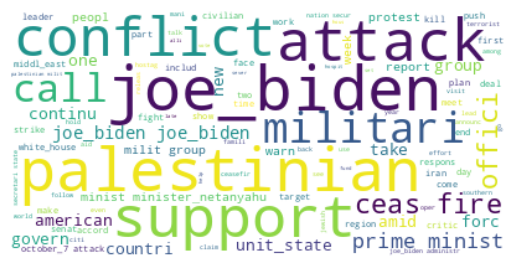

In [43]:
#Word Cloud
#documents_clean_text_feature
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Join the clean_text_feature words in each document into a single string
text = " ".join(documents_clean_text_feature)

# Create the WordCloud object
wc = WordCloud(background_color="white", max_words=100, max_font_size=50)

# Generate the word cloud
wc.generate(text)

# Display the word cloud
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()


In [44]:

# Create a dictionary to store the word frequencies
word_counts = {}

# Loop through each document and count the words
for document in documents_clean_text_feature:
    for word in document.split():
        if word not in word_counts:
            word_counts[word] = 0
        word_counts[word] += 1

# Sort the dictionary by word frequency
sorted_word_counts = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)

# Print the top 20 most frequent words
print("Top 30 most frequent words:")
for word, count in sorted_word_counts[:50]:
    print(f"{word}: {count}")
print("*****************")

# Print the top 20 least frequent words by starting from the end of the sorted list
print("Top 30 least frequent words:")
for word, count in sorted_word_counts[-50:]:
    print(f"{word}: {count}")


Top 30 most frequent words:
joe_biden: 1353
palestinian: 1058
attack: 1010
group: 632
militari: 546
call: 546
conflict: 489
hostag: 478
fire: 461
support: 454
aid: 443
offici: 439
milit: 427
october_7: 424
state: 408
week: 408
kill: 395
minist: 394
peopl: 382
secur: 369
day: 362
forc: 360
two: 338
take: 336
american: 329
sinc: 325
civilian: 314
fight: 310
ceas: 309
releas: 295
amid: 282
prime: 281
new: 280
leader: 278
would: 273
hospit: 273
border: 270
nation: 264
back: 264
senat: 262
defens: 259
protest: 256
month: 254
one: 252
govern: 249
citi: 245
intern: 244
strike: 238
follow: 238
deal: 237
*****************
Top 30 least frequent words:
haredim: 1
exempt: 1
mandatori: 1
3426: 1
unsustain: 1
sarcast: 1
cumbersom: 1
substitut: 1
trinidadian: 1
technic: 1
chokeslam: 1
midtown: 1
eid: 1
bazaar: 1
vendor: 1
merchandis: 1
awkward: 1
netanyu: 1
territorya: 1
voyag: 1
golan: 1
minsit: 1
redefin: 1
delegitim: 1
vanish: 1
speciou: 1
dolbi: 1
theatr: 1
sartori: 1
wardrob: 1
96th: 1
wore: 1
v

In [45]:
from collections import Counter

bigrams_counter = Counter()

for bigrams_list in clean_dfgnews['Bigrams']:
    bigrams_counter.update(bigrams_list.split())

most_common_bigrams = bigrams_counter.most_common(30)
least_common_bigrams = bigrams_counter.most_common()[:-31:-1]

print("Top 30 most frequent bigrams:")
for bigram, count in most_common_bigrams:
    print(f"{bigram}: {count}")

print("\nTop 30 least frequent bigrams:")
for bigram, count in least_common_bigrams:
    print(f"{bigram}: {count}")


Top 30 most frequent bigrams:
ceas_fire: 304
prime_minist: 277
joe_biden_joe_biden: 272
minist_minister_netanyahu: 199
milit_group: 182
october_7_attack: 182
joe_biden_administr: 128
nation_secur: 114
secretari_state: 112
palestinian_milit: 110
state_antoni_blinken: 95
defens_forc: 85
death_toll: 71
live_updat: 69
paus_fight: 67
secur_council: 65
call_ceas: 62
hostag_releas: 62
south_africa: 62
terror_attack: 61
surpris_attack: 60
four_day: 59
ground_offens: 55
mike_johnson: 55
ground_invas: 54
red_sea: 53
humanitarian_paus: 50
iran_back: 49
follow_nbc_news: 47
aid_packag: 47

Top 30 least frequent bigrams:
stronghold_gazan: 1
last_stronghold: 1
dismantl_last: 1
oper_dismantl: 1
forward_militari: 1
assist_move: 1
might_cut: 1
suggest_might: 1
fund_organ: 1
week_mani: 1
offici_week: 1
set_meet: 1
unrwa_set: 1
associ_unrwa: 1
alleg_associ: 1
probe_alleg: 1
united_nation_probe: 1
tap_lead: 1
minist_tap: 1
colonna_former: 1
deprav_light: 1
relationship_deprav: 1
call_relationship: 1
depart

### This step helped us throughout the process to quickly understand whether there are words that are **stop words** and whether there are different combinations and expressions that need to be united due to the identical meaning.
### At this stage you can see the words after filtering and adjusting the combinations. This step was performed in several iterations to maximize the meaningful words and conjunctions to prepare clear and well-separated text for the model.

It is possible that we could have continued cleaning the data or using different libraries to understand the semantic meaning within the sentences, but we still saw later that the issue was not completely necessary.



---


#CLUSTERING - Modeling


### TF-IDF

In [46]:
# #function to vectorize strings and perform tf-idf transformation
# def vectorize_texts(list_of_strings):
#     print('Performing vectorization and TF/IDF transformation on texts...')
#     vectorizer = CountVectorizer()
#     X = vectorizer.fit_transform(list_of_strings)
#     transformer = TfidfTransformer(smooth_idf=False)
#     tfidf = transformer.fit_transform(X)
#     return tfidf

## Examining parameters for TF-IDF

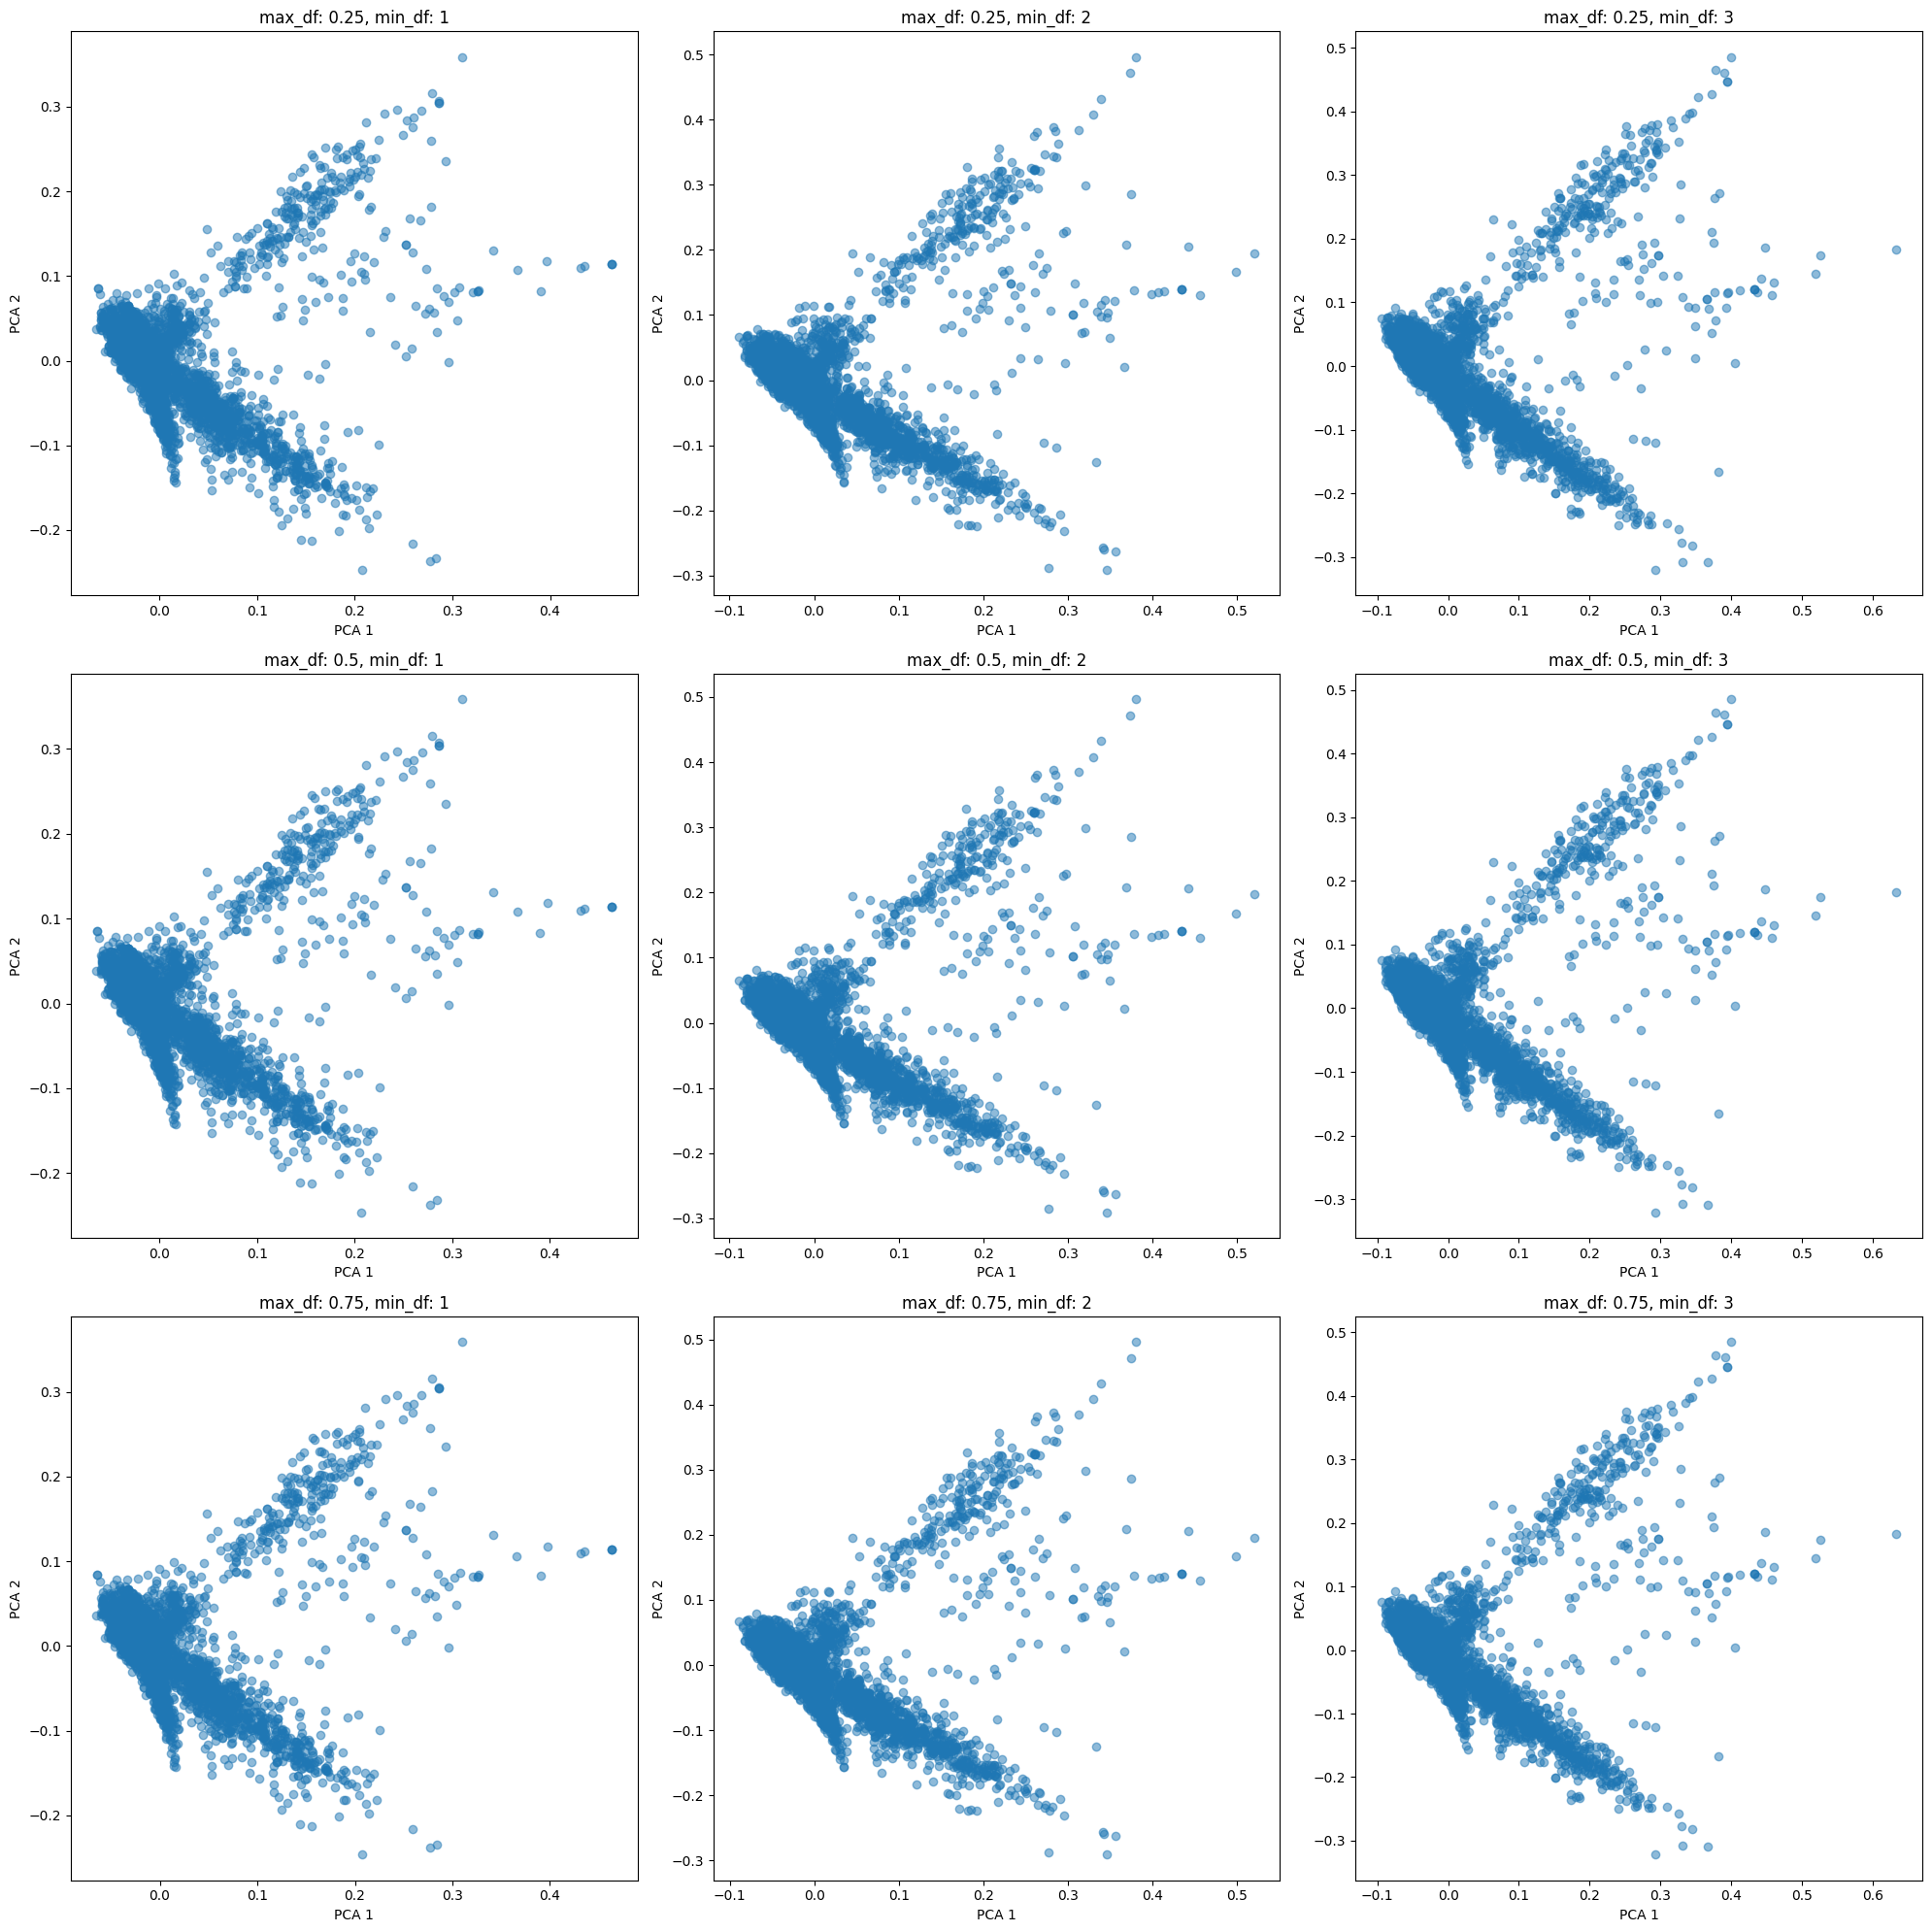

In [47]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Function to vectorize texts with TF-IDF and visualize using PCA
def visualize_tfidf_params(list_of_strings, max_df_values, min_df_values):
    fig, axes = plt.subplots(len(max_df_values), len(min_df_values), figsize=(20, 20))

    for i, max_df in enumerate(max_df_values):
        for j, min_df in enumerate(min_df_values):
            # Vectorize with the current set of parameters
            tfidf_vectorizer = TfidfVectorizer(
                ngram_range=(1, 2),
                max_df=max_df,
                min_df=min_df,
                stop_words='english'
            )
            tfidf_matrix = tfidf_vectorizer.fit_transform(list_of_strings)

            # Apply PCA
            pca = PCA(n_components=2)
            pca_result = pca.fit_transform(tfidf_matrix.toarray())

            # Plot
            ax = axes[i, j] if len(max_df_values) > 1 and len(min_df_values) > 1 else axes[max(i, j)]
            ax.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.5)
            ax.set_title(f'max_df: {max_df}, min_df: {min_df}')
            ax.set_xlabel('PCA 1')
            ax.set_ylabel('PCA 2')

    plt.tight_layout()
    plt.show()

# Example usage with a range of parameter values
max_df_values = [0.25, 0.5, 0.75]
min_df_values = [1, 2, 3]
visualize_tfidf_params(documents_clean_text_feature, max_df_values, min_df_values)


### **Choose the Right Parameters:** It seems that a `max_df` value of **0.5** provides a good spread of data points without being too restrictive. For `min_df`, a value of **1 or 2** seems reasonable. You want to capture enough word variability without introducing too much noise.


---



In [48]:
# Let's use TF-IDF with chosen parameters
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_df=0.5, min_df=1, stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(documents_clean_text_feature)

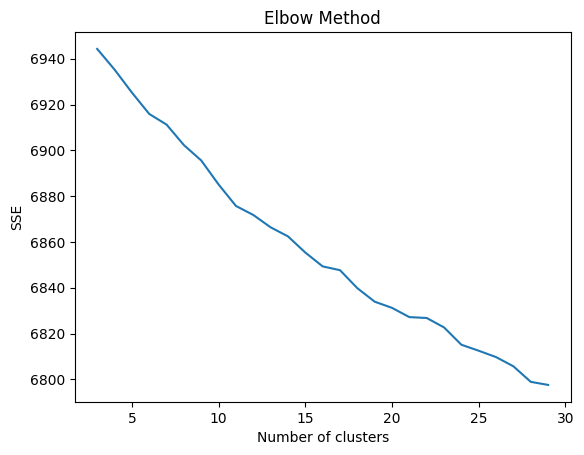

In [49]:

# Find optimal number of clusters using the elbow method
sse = []
for k in range(3, 30):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(tfidf_matrix)
    sse.append(kmeans.inertia_)

# Plot SSE for each *k*
plt.plot(range(3, 30), sse)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.show()

At this stage we understood that it would be complex to find an optimal K and the assessment of the classification quality would be challenging

### We will try to examine in a preliminary way some models that can help in classifying the articles

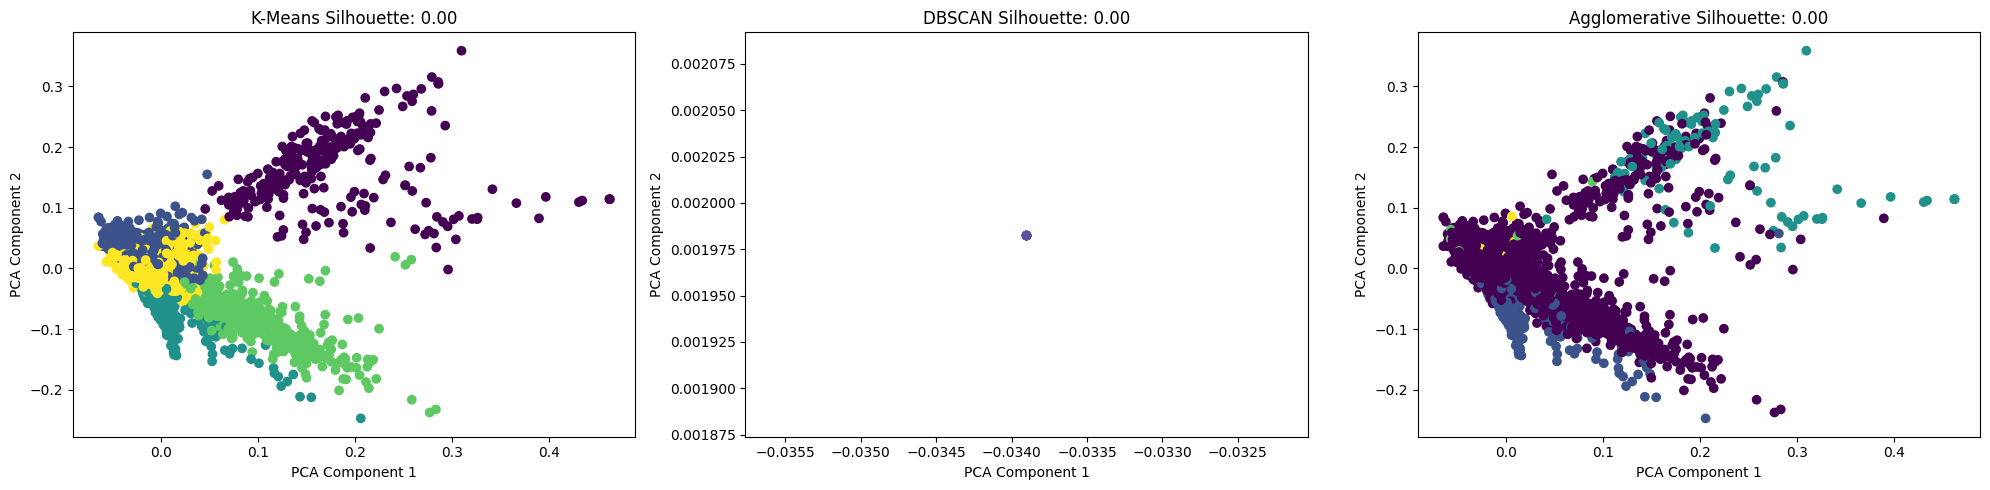

In [50]:
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

def cluster_and_visualize(tfidf_matrix, true_k):
    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(tfidf_matrix.toarray())

    # K-Means
    kmeans = KMeans(n_clusters=true_k, random_state=42)
    kmeans.fit(tfidf_matrix)
    kmeans_labels = kmeans.labels_
    silhouette_kmeans = silhouette_score(tfidf_matrix, kmeans_labels)

    # DBSCAN
    dbscan = DBSCAN(eps=0.5, min_samples=5)
    dbscan.fit(tfidf_matrix)
    dbscan_labels = dbscan.labels_
    # Silhouette score is only meaningful if there are more than one cluster identified by DBSCAN
    silhouette_dbscan = silhouette_score(tfidf_matrix, dbscan_labels) if len(set(dbscan_labels)) > 1 else -1

    # Hierarchical Clustering
    hierarchical = AgglomerativeClustering(n_clusters=true_k)
    hierarchical.fit(tfidf_matrix.toarray())
    hierarchical_labels = hierarchical.labels_
    silhouette_hierarchical = silhouette_score(tfidf_matrix, hierarchical_labels)

    # Plotting
    fig, ax = plt.subplots(1, 3, figsize=(20, 5))

    # K-Means plot
    ax[0].scatter(reduced_data[:, 0], reduced_data[:, 1], c=kmeans_labels)
    ax[0].set_title(f'K-Means Silhouette: {silhouette_kmeans:.2f}')

    # DBSCAN plot
    unique_labels = np.unique(dbscan_labels)
    colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
    for color, label in zip(colors, unique_labels):
        if label == -1:  # Noise
            continue
        ax[1].scatter(reduced_data[dbscan_labels == label, 0], reduced_data[dbscan_labels == label, 1], c=[color])
    ax[1].set_title(f'DBSCAN Silhouette: {silhouette_dbscan:.2f}')

    # Hierarchical plot
    ax[2].scatter(reduced_data[:, 0], reduced_data[:, 1], c=hierarchical_labels)
    ax[2].set_title(f'Agglomerative Silhouette: {silhouette_hierarchical:.2f}')

    for a in ax:
        a.set_xlabel('PCA Component 1')
        a.set_ylabel('PCA Component 2')
    plt.tight_layout()
    plt.show()

# Assuming tfidf_matrix is your TF-IDF matrix
# Replace 'true_k' with the optimal number of clusters you've determined from the elbow method or set it to None for DBSCAN
cluster_and_visualize(tfidf_matrix, true_k=5)


>### It seems that **K-Means and Agglomerative** manage to classify well but **DBSCAN** does not.
>### We thought it could be related to its parameters because it has a significant effect on DBSCAN and it is possible that due to the high density between the points the parameters are not well defined. That's why we wanted to examine what happens when the model is tested with different parameters.

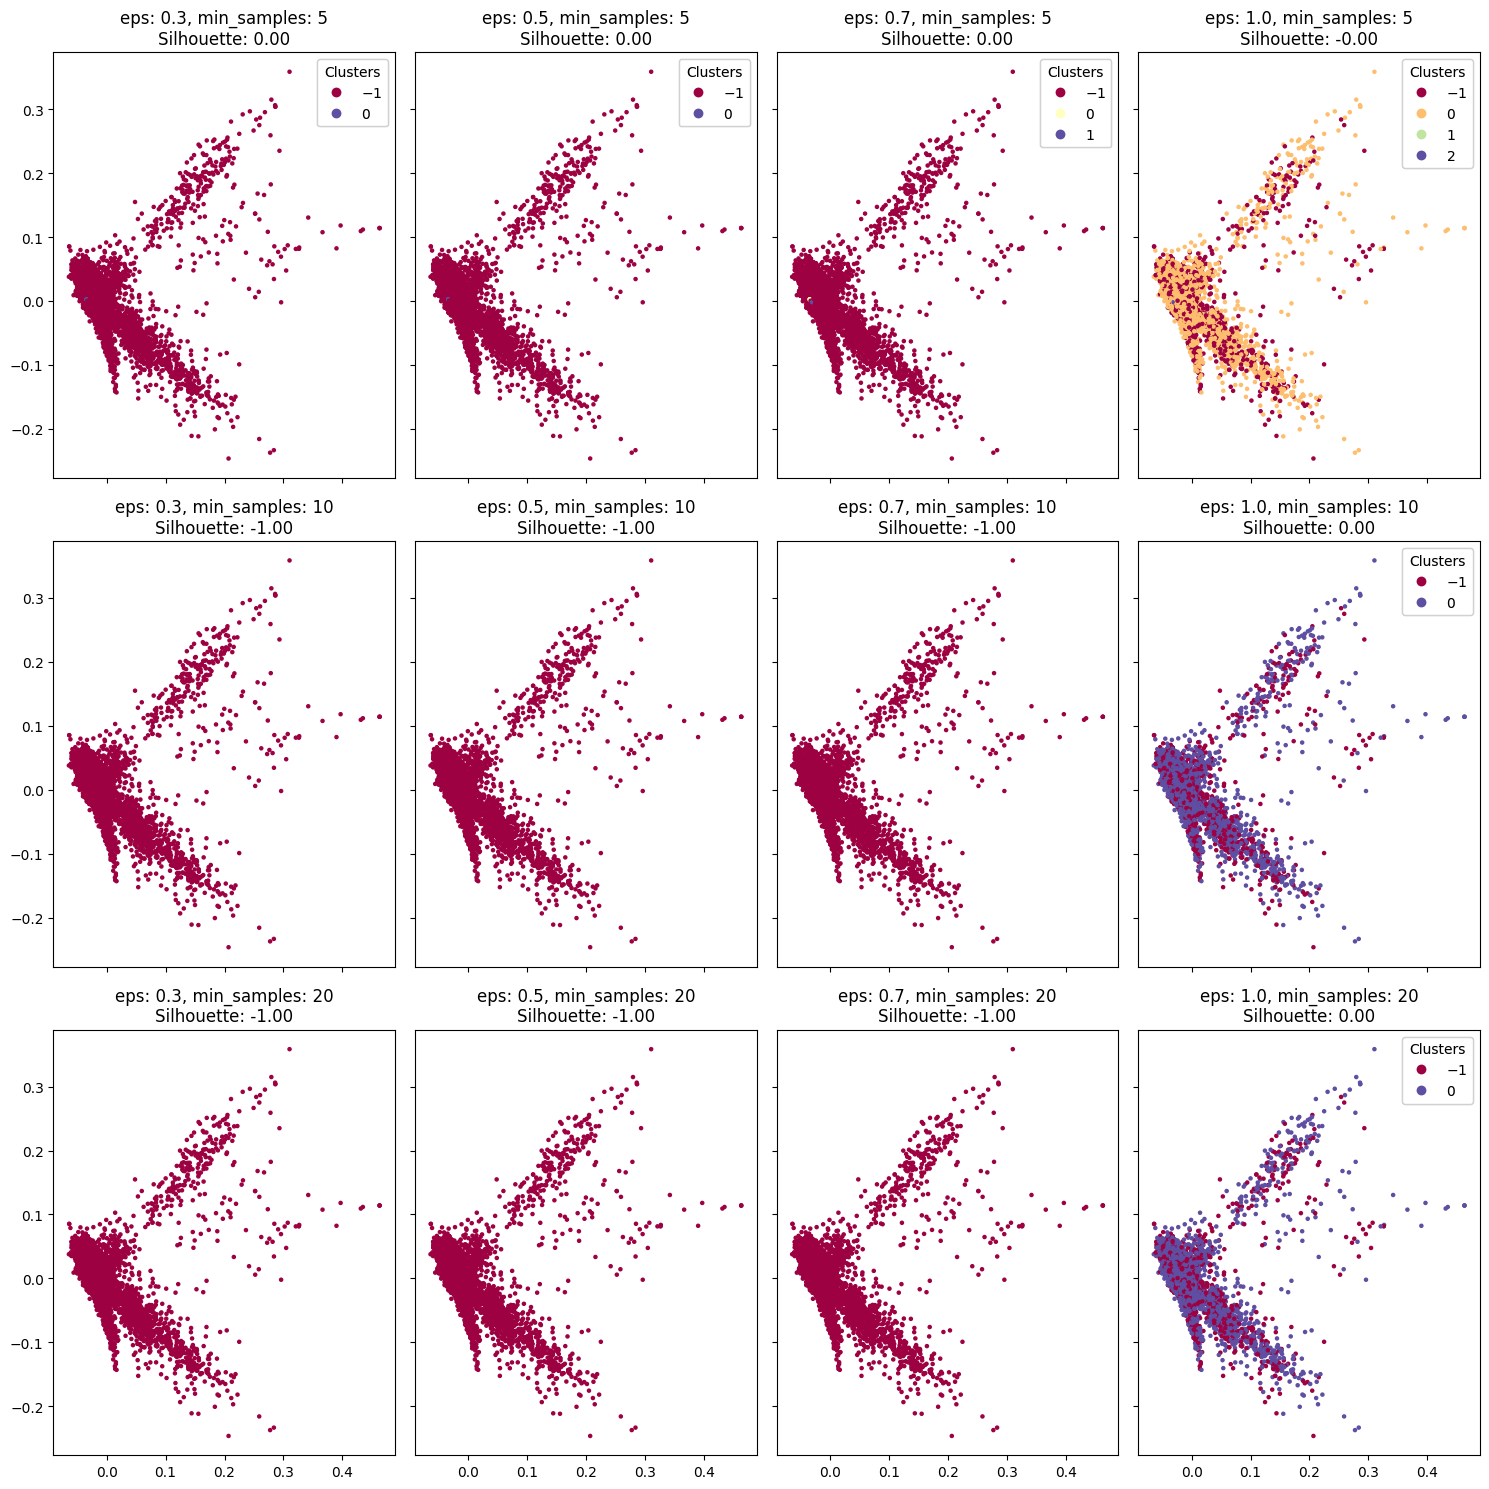

In [51]:
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

def dbscan_param_search(tfidf_matrix, eps_values, min_samples_values):
    # First, we reduce the dimensionality for visualization
    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(tfidf_matrix.toarray())

    fig, axes = plt.subplots(len(min_samples_values), len(eps_values), figsize=(15, 15), sharex=True, sharey=True)

    for i, min_samples in enumerate(min_samples_values):
        for j, eps in enumerate(eps_values):
            # DBSCAN with the current set of parameters
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            labels = dbscan.fit_predict(tfidf_matrix)

            # Silhouette score, we will compute it only if more than one cluster is present
            silhouette = silhouette_score(tfidf_matrix, labels) if len(np.unique(labels)) > 1 else -1

            ax = axes[i][j]
            # Plotting the PCA-reduced data with the DBSCAN cluster assignments
            scatter = ax.scatter(reduced_data[:, 0], reduced_data[:, 1], c=labels, cmap='Spectral', s=5)
            ax.set_title(f'eps: {eps}, min_samples: {min_samples}\nSilhouette: {silhouette:.2f}')

            # We create a legend only if we have more than noise
            if len(np.unique(labels)) > 1:
                legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
                ax.add_artist(legend1)

    plt.tight_layout()
    plt.show()

# Example usage
eps_values = [0.3, 0.5, 0.7, 1.0]  # Example epsilon values
min_samples_values = [5, 10, 20]  # Example min_samples values
dbscan_param_search(tfidf_matrix, eps_values, min_samples_values)


>### **DBSCAN** seems unsuitable for your dataset because it classified most data points as noise, indicating the absence of distinct density-based clusters. The high dimensionality and lack of clear separation between points make parameter tuning challenging, resulting in poor silhouette scores. On the other hand, **K-Means**, while not perfect, offers more consistent clustering by minimizing variance within clusters, suggesting that it may be more effective for this particular dataset.











## Agglomerative Clustering

Converting sparse matrix to dense (this may take a while)...
Reducing dimensionality to 2 components...
Performing agglomerative clustering for 5 clusters...
Performing agglomerative clustering for 8 clusters...
Performing agglomerative clustering for 10 clusters...
Performing agglomerative clustering for 15 clusters...


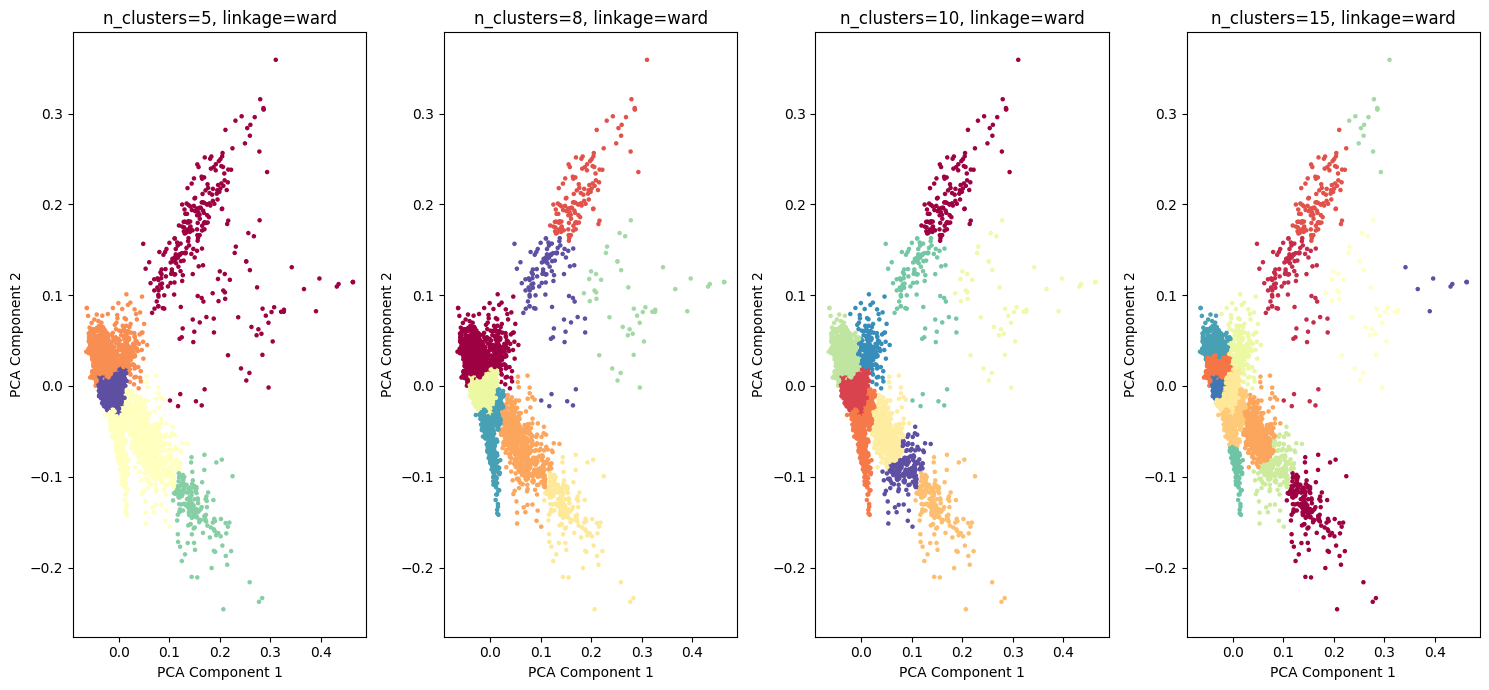

In [52]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix

def visualize_agglomerative_clustering(tfidf_matrix, num_clusters_list, linkage='ward', n_components=2):
    # Convert to dense if the matrix is sparse and very large
    if isinstance(tfidf_matrix, csr_matrix):
        print("Converting sparse matrix to dense (this may take a while)...")
        tfidf_matrix = tfidf_matrix.toarray()

    # Reduce the dimensionality for faster computation and visualization
    print(f"Reducing dimensionality to {n_components} components...")
    pca = PCA(n_components=n_components)
    reduced_data = pca.fit_transform(tfidf_matrix)

    plt.figure(figsize=(15, 7))

    for i, n_clusters in enumerate(num_clusters_list):
        # Perform Agglomerative Clustering
        print(f"Performing agglomerative clustering for {n_clusters} clusters...")
        agglom = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage, compute_full_tree='auto')
        labels = agglom.fit_predict(reduced_data)

        plt.subplot(1, len(num_clusters_list), i + 1)
        plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=labels, cmap='Spectral', s=5)
        plt.title(f'n_clusters={n_clusters}, linkage={linkage}')
        plt.xlabel('PCA Component 1')
        plt.ylabel('PCA Component 2')

    plt.tight_layout()
    plt.show()

# Assuming tfidf_matrix is your TF-IDF matrix
num_clusters_list = [5, 8, 10 ,15]  # Limiting to a few cluster counts for simplicity
visualize_agglomerative_clustering(tfidf_matrix, num_clusters_list)




---

## K-means



Converting sparse matrix to dense (this may take a while)...
Reducing dimensionality to 2 components...
Performing K-Means clustering for 5 clusters...
Performing K-Means clustering for 8 clusters...
Performing K-Means clustering for 10 clusters...
Performing K-Means clustering for 15 clusters...


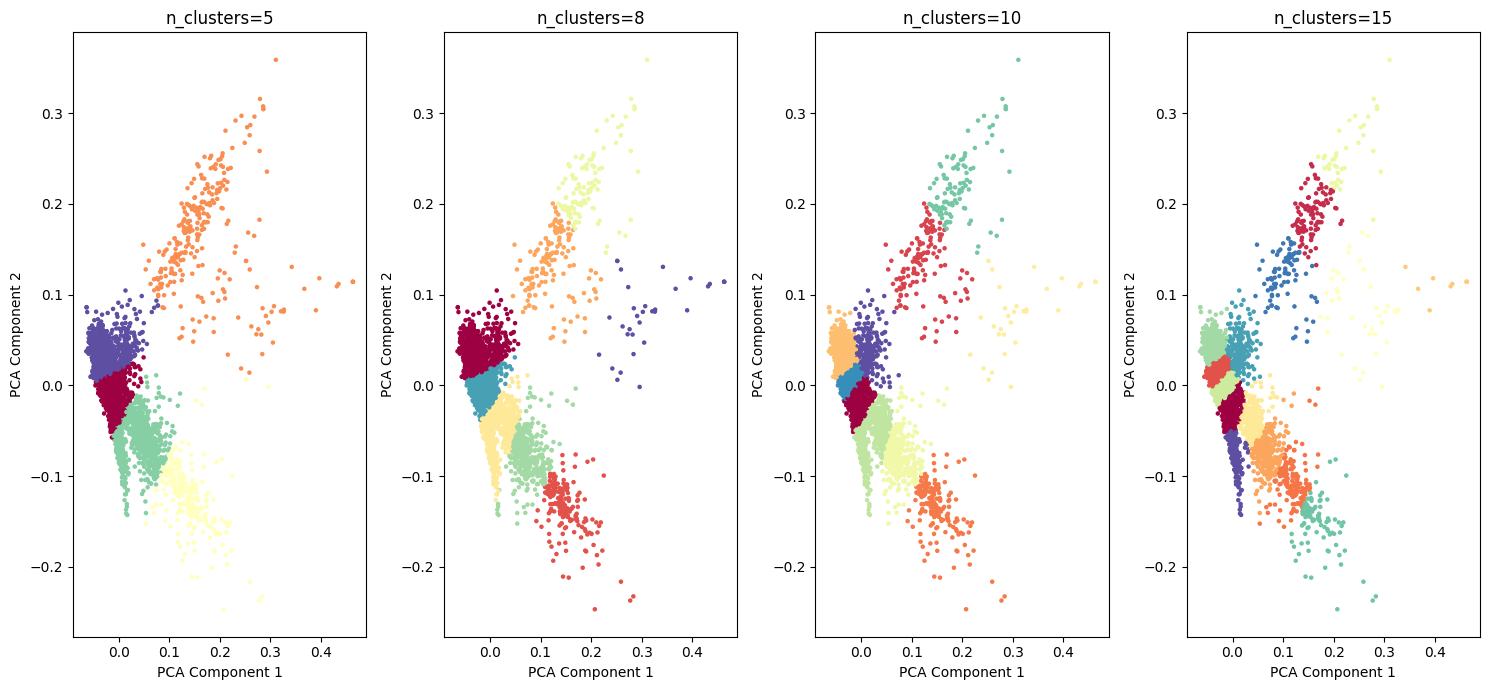

In [53]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix

def visualize_kmeans_clustering(tfidf_matrix, num_clusters_list, n_components=2, random_state=None):
    # Convert to dense if the matrix is sparse and very large
    if isinstance(tfidf_matrix, csr_matrix):
        print("Converting sparse matrix to dense (this may take a while)...")
        tfidf_matrix = tfidf_matrix.toarray()

    # Reduce the dimensionality for faster computation and visualization
    print(f"Reducing dimensionality to {n_components} components...")
    pca = PCA(n_components=n_components)
    reduced_data = pca.fit_transform(tfidf_matrix)

    plt.figure(figsize=(15, 7))

    for i, n_clusters in enumerate(num_clusters_list):
        # Perform K-Means Clustering
        print(f"Performing K-Means clustering for {n_clusters} clusters...")
        kmeans = KMeans(n_clusters=n_clusters, random_state=random_state)
        labels = kmeans.fit_predict(reduced_data)

        plt.subplot(1, len(num_clusters_list), i + 1)
        plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=labels, cmap='Spectral', s=5)
        plt.title(f'n_clusters={n_clusters}')
        plt.xlabel('PCA Component 1')
        plt.ylabel('PCA Component 2')

    plt.tight_layout()
    plt.show()

# Assuming tfidf_matrix is your TF-IDF matrix
num_clusters_list = [5, 8, 10, 15]  # Limiting to a few cluster counts for simplicity
visualize_kmeans_clustering(tfidf_matrix, num_clusters_list)


### It seems that K-Means and Agglomerative also manage to find different groups of subjects in the data.
We will try to evaluate which **K** is ideal for the task and also do compute silhouette scores in order to understand whether we will classify qualitatively and whether there is good separation in the data or whether this will be suboptimal because the topics are very overlapping.


---



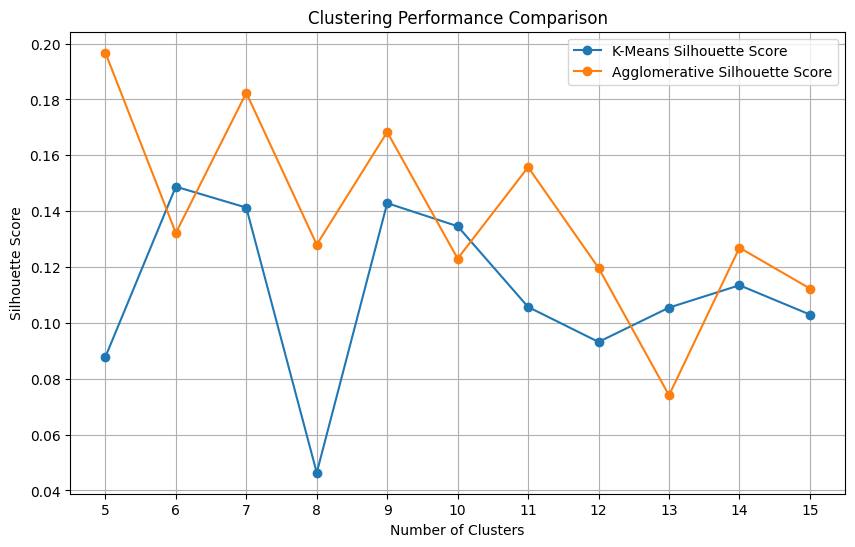

In [54]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.decomposition import PCA
from scipy.sparse import csr_matrix
import numpy as np
import matplotlib.pyplot as plt

def compute_silhouette_scores(tfidf_matrix, cluster_range, model='kmeans', random_state=None):
    scores = []
    for n_clusters in cluster_range:
        if model == 'kmeans':
            clusterer = KMeans(n_clusters=n_clusters, random_state=random_state)
        elif model == 'agglomerative':
            clusterer = AgglomerativeClustering(n_clusters=n_clusters)
        else:
            raise ValueError("Model must be 'kmeans' or 'agglomerative'")

        # Reduce dimensionality for large sparse matrices
        if isinstance(tfidf_matrix, csr_matrix) and tfidf_matrix.shape[1] > 50:
            pca = PCA(n_components=50)
            reduced_data = pca.fit_transform(tfidf_matrix.toarray())
        else:
            reduced_data = tfidf_matrix

        cluster_labels = clusterer.fit_predict(reduced_data)
        silhouette_avg = silhouette_score(reduced_data, cluster_labels)
        scores.append(silhouette_avg)
    return scores

def visualize_performance(cluster_range, kmeans_scores, agg_scores):
    plt.figure(figsize=(10, 6))
    plt.plot(cluster_range, kmeans_scores, label='K-Means Silhouette Score', marker='o')
    plt.plot(cluster_range, agg_scores, label='Agglomerative Silhouette Score', marker='o')
    plt.xticks(cluster_range)
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    plt.title('Clustering Performance Comparison')
    plt.legend()
    plt.grid(True)
    plt.show()

# Assuming tfidf_matrix is your TF-IDF matrix
cluster_range = range(5, 16)  # K values from 5 to 15
kmeans_scores = compute_silhouette_scores(tfidf_matrix, cluster_range, model='kmeans')
agg_scores = compute_silhouette_scores(tfidf_matrix, cluster_range, model='agglomerative')

# Visualize the performance
visualize_performance(cluster_range, kmeans_scores, agg_scores)



This graph compares the silhouette scores for **K-Means and Agglomerative** clustering methods across different cluster counts. The silhouette score is a measure of cluster cohesion and separation; higher scores indicate better-defined clusters. Peaks in the graph suggest optimal numbers of clusters for each method, where the data points are grouped most effectively into distinct clusters.

It seems that due to the high overlap between the topics there is no ideal K, but we will try to see if it is possible to divide the articles into topics.


---



## K-means clustering

In [55]:
# Function to perform K-Means clustering, print top terms for each cluster, and return labels
def kmeans_clustering_and_top_terms(tfidf_matrix, num_clusters=6, n_terms=20):
    # Perform K-Means clustering
    kmeans = KMeans(n_clusters=num_clusters, max_iter=100, verbose=2, n_init=1)
    cluster_labels = kmeans.fit_predict(tfidf_matrix)

    # Print silhouette score for the clustering
    silhouette_avg = silhouette_score(tfidf_matrix, cluster_labels)
    print(f"Silhouette Score for K-Means with {num_clusters} clusters: {silhouette_avg}")

    # Get feature names to print top terms
    tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

    # Get top terms for each cluster
    order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
    print("Top terms per cluster:")
    cluster_terms = {}
    for i in range(num_clusters):
        print(f"Cluster {i}: ", end='')
        top_terms = [tfidf_feature_names[ind] for ind in order_centroids[i, :n_terms]]
        print(", ".join(top_terms))
        cluster_terms[i] = top_terms

    # Return labels and terms for further analysis
    return cluster_labels, cluster_terms

# Assuming tfidf_matrix is already defined and tfidf_vectorizer is fitted
num_clusters = 15
cluster_labels, cluster_terms = kmeans_clustering_and_top_terms(tfidf_matrix, num_clusters=num_clusters)

# Add initial cluster labels to your DataFrame
clean_dfgnews['initial_cluster'] = cluster_labels


Initialization complete
Iteration 0, inertia 13454.72845174693.
Iteration 1, inertia 6904.7745533620655.
Iteration 2, inertia 6888.8275536084675.
Iteration 3, inertia 6881.058431606178.
Iteration 4, inertia 6876.05330159265.
Iteration 5, inertia 6872.169777745337.
Iteration 6, inertia 6870.1252511227785.
Iteration 7, inertia 6868.9506208881285.
Iteration 8, inertia 6868.163014281453.
Iteration 9, inertia 6867.618071664158.
Iteration 10, inertia 6867.294996889618.
Iteration 11, inertia 6867.080345528925.
Iteration 12, inertia 6866.88545889249.
Iteration 13, inertia 6866.6752517038085.
Iteration 14, inertia 6866.547105427644.
Iteration 15, inertia 6866.491822308372.
Iteration 16, inertia 6866.449241676811.
Iteration 17, inertia 6866.411149754537.
Iteration 18, inertia 6866.380628655227.
Iteration 19, inertia 6866.366587185356.
Iteration 20, inertia 6866.337332876768.
Iteration 21, inertia 6866.267691389705.
Iteration 22, inertia 6866.018767986978.
Iteration 23, inertia 6865.620777685537.

### The largest cluster

In [57]:


# Count occurrences of each label to find the largest cluster
(unique, counts) = np.unique(cluster_labels, return_counts=True)
largest_cluster = unique[np.argmax(counts)]
largest_cluster_size = counts[np.argmax(counts)]

print(f"The largest cluster is Cluster {largest_cluster} with {largest_cluster_size} elements.")

# Optionally, display some top terms of the largest cluster for context
print(f"Top terms in the largest cluster (Cluster {largest_cluster}): {', '.join(cluster_terms[largest_cluster][:10])}")

# Filter the DataFrame to display only the rows belonging to the largest cluster
largest_cluster_df = clean_dfgnews[clean_dfgnews['initial_cluster'] == largest_cluster]

# Display the DataFrame rows belonging to the largest cluster
# You can use .head() to display just the first few rows
print("Displaying some articles from the largest cluster:")
largest_cluster_df.head()


The largest cluster is Cluster 9 with 2976 elements.
Top terms in the largest cluster (Cluster 9): palestinian, attack, group, support, jewish, militari, protest, week, american, govern
Displaying some articles from the largest cluster:


title  \
208  A San Fernando Valley athlete will be represen...   
210  Palestinian gunmen reported in Israel as barra...   
214                             On This Day in History   
216  US tourist arrested for smashing Roman statues...   
220  American tourist arrested for smashing statues...   

                                           description  \
208  Israel Mateos says frontball isn't typically p...   
210  Palestinian gunmen reported in Israel as barra...   
214  On Oct. 6, 1973, Egypt and Syria launched a co...   
216  Israeli police have arrested an American touri...   
220  An American tourist was arrested at the Israel...   

                                               content  \
208  Israel Mateos is representing Team USA at this...   
210  Published Oct 07, 2023 12:49AM ET Updated Oct ...   
214  1 of 4 | Israeli soldiers lay flowers at a war...   
216  Israeli police have arrested an American touri...   
220  An American tourist was arrested at the Israel...   

                                                   url  \
208  https://abc7.com/israel-mateos-frontball-pan-a...   
210  https://www.investing.com/news/world-news/rock...   
214  https://www.upi.com/Top_News/2023/10/06/UPI-Al...   
216  https://www.nbcboston.com/news/national-intern...   
220  https://www.nbcnews.com/news/world/american-to...   

                  publishedAt  len_content_article  len_description_article  \
208 2023-10-06 00:11:11+00:00                  266                       97   
210 2023-10-06 04:00:00+00:00                  266                       68   
214 2023-10-06 07:00:07+00:00                  266                      175   
216 2023-10-06 08:31:41+00:00                  266                      162   
220 2023-10-06 13:53:37+00:00                  266                      172   

                                       first_250_words  \
208  israel mateos says frontball isn't typically p...   
210  palestinian gunmen reported in israel as barra...   
214  on oct. 6, 1973, egypt and syria launched a co...   
216  israeli police have arrested an american touri...   
220  an american tourist was arrested at the israel...   

                sent_word_tokenized_first_250_no_stops  \
208  [israel, mateos, says, frontball, isnt, typica...   
210  [palestinian, gunmen, reported, israel, barrag...   
214  [oct, 6, 1973, egypt, syria, launched, coordin...   
216  [israeli, police, arrested, american, tourist,...   
220  [american, tourist, arrested, israel, museum, ...   

                                               stemmed  \
208  israel mateo say frontbal isnt typic play us p...   
210  palestinian gunmen report israel barrag launch...   
214  oct 6 1973 egypt syria launch coordin attack i...   
216  isra polic arrest american tourist israel muse...   
220  american tourist arrest israel museum jerusale...   

                                       lemmatized_text  \
208          mateo frontbal isnt typic play plan chang   
210            palestinian gunman report barrag launch   
214  oct 6 1973 egypt syria launch coordin attack y...   
216  polic arrest american tourist museum jerusalem...   
220  american tourist arrest museum jerusalem alleg...   

                                    clean_text_feature  \
208          mateo frontbal isnt typic play plan chang   
210            palestinian gunman report barrag launch   
214  october 6 1973 egypt syria launch coordin atta...   
216  polic arrest american tourist museum jerusalem...   
220  american tourist arrest museum jerusalem alleg...   

                                               Bigrams  initial_cluster  
208  mateo_frontbal frontbal_isnt isnt_typic typic_...                9  
210  palestinian_gunman gunman_report report_barrag...                9  
214  october_6 6_1973 1973_egypt egypt_syria syria_...                9  
216  polic_arrest arrest_american american_tourist ...                9  
220  american_tourist tourist_arrest arrest_museum ...         


### Cluster 0: "Military Operations and Humanitarian Impact"
> **General Idea**: Involves military actions, court orders, potentially involving operations in hospitals and claims about civilian casualties.
---

### Cluster 1: "Political Leadership and International Courts"
> **General Idea**: Focuses on political leadership, international legal actions, and accusations, possibly involving genocide cases and UN hearings.
---

### Cluster 2: "US Aid and Legislative Actions"
> **General Idea**: Centers around US aid, legislative processes, and the involvement of political figures, with a focus on funding packages and votes.
---

### Cluster 3: "Biden Administration and Policy Influence"
> **General Idea**: Discusses the Biden administration's support, policies, and its influence on various conflicts, including the Palestinian issue.
---

### Cluster 4: "US Security Policies and Administration"
> **General Idea**: Relates to US security policies, national security considerations, and the administration's stance on Palestinian groups.
---

### Cluster 5: "Houthi Strikes and Regional Tensions"
> **General Idea**: Covers Houthi strikes, maritime security concerns, and regional tensions, including Hezbollah's involvement and Iranian influence.
---

### Cluster 6: "Diplomatic Visits and Middle East Focus"
> **General Idea**: Involves key diplomatic figures and their visits, with a focus on Middle East affairs, civilian protection, and regional stability.
---

### Cluster 7: "Academic Environment and Antisemitism"
> **General Idea**: Deals with the academic environment, student activities, and issues of antisemitism on campuses, particularly at Harvard and Columbia.
---

### Cluster 8: "Hostage Situations and Negotiations"
> **General Idea**: Revolves around hostage releases, truces, and the intricacies of negotiation deals, including prisoner exchanges.
---

### Cluster 9: "Social Unrest and Political Support"
> **General Idea**: Focuses on social unrest, support for various groups, and the role of the military and government in addressing conflicts.
---

### Cluster 10: "Government Leadership and Military Strategy"
> **General Idea**: Centers on government leadership, military strategies, and diplomatic interactions, particularly involving Prime Minister Netanyahu.
---

### Cluster 11: "Casualties and Border Conflicts"
> **General Idea**: Discusses casualties, border conflicts, and the humanitarian impact of military offensives, with a focus on southern regions.
---

### Cluster 12: "Ground Invasions and Security Council Resolutions"
> **General Idea**: Involves discussions on ground invasions, security council resolutions, and calls for humanitarian pauses in conflicts.
---

### Cluster 13: "Terror Attacks and Public Reaction"
> **General Idea**: Specific focus on terror attacks, their aftermath, and public and political reactions to these events.
---

### Cluster 14: "Live Updates and Conflict Coverage"
> **General Idea**: Relates to live updates and comprehensive news coverage of conflicts, with a focus on the Palestinian conflict and regional escalations.

---
---
>**These titles and summaries offer a snapshot of each cluster's thematic focus based on the top terms, providing an intuitive understanding of the underlying topics.**


---


In [58]:
cluster_titles = {
    0: "Military Operations and Humanitarian Impact",
    1: "Political Leadership and International Courts",
    2: "US Aid and Legislative Actions",
    3: "Biden Administration and Policy Influence",
    4: "US Security Policies and Administration",
    5: "Houthi Strikes and Regional Tensions",
    6: "Diplomatic Visits and Middle East Focus",
    7: "Academic Environment and Antisemitism",
    8: "Hostage Situations and Negotiations",
    9: "Social Unrest and Political Support",
    10: "Government Leadership and Military Strategy",
    11: "Casualties and Border Conflicts",
    12: "Ground Invasions and Security Council Resolutions",
    13: "Terror Attacks and Public Reaction",
    14: "Live Updates and Conflict Coverage"
}


In [59]:
clean_dfgnews['cluster_title'] = clean_dfgnews['initial_cluster'].map(cluster_titles)

In [60]:


clean_dfgnews.to_csv('clean_dfgnews_cluster_title.csv')


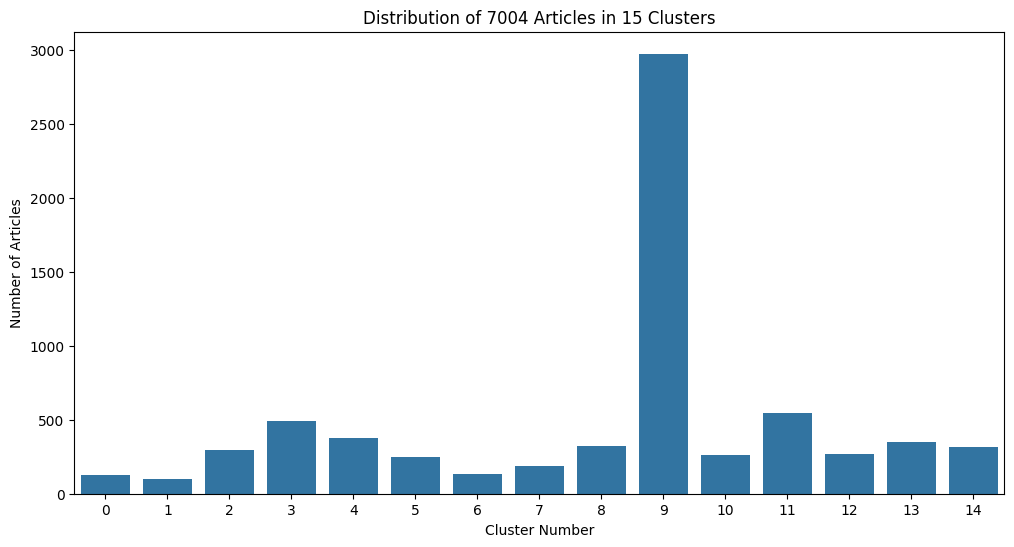

In [61]:
# Generate bar plot for the distribution of articles per cluster
def plot_cluster_distribution(cluster_labels, num_clusters):
    # Convert cluster assignments into a DataFrame for easier counting
    cluster_assignment_df = pd.DataFrame({'Article': range(len(cluster_labels)), 'Cluster': cluster_labels})

    # Count the number of articles per cluster
    cluster_counts = cluster_assignment_df['Cluster'].value_counts().sort_index()

    # Create a bar plot showing the distribution of articles per cluster
    plt.figure(figsize=(12, 6))
    sns.barplot(x=cluster_counts.index, y=cluster_counts.values)
    plt.title(f'Distribution of {len(cluster_assignment_df)} Articles in {num_clusters} Clusters')
    plt.xlabel('Cluster Number')
    plt.ylabel('Number of Articles')
    plt.show()

# Call the function to plot the distribution
plot_cluster_distribution(cluster_labels, num_clusters)

At this point we realized that there is a central topic that most of the articles deal with. It is a logical situation that there is no uniform distribution of topics in news articles, especially during wartime.
In addition, many topics have a high overlap with each other and are connected to each other, which makes it difficult to separate them into groups.

Another explanation for this is the topic that the largest classer represents:

### Cluster 9: "Social Unrest and Political Support"
> **General Idea**: Focuses on social unrest, support for various groups, and the role of the military and government in addressing conflicts.
---

>It makes sense that this topic occupies a lot of headlines in the US around the war because it is happening all over the US and most concerns the American population.
Since it includes many topics for protest, it probably also includes some topics that make classification difficult.


---

####We will try to examine what happens when we remove the most frequent cluster.

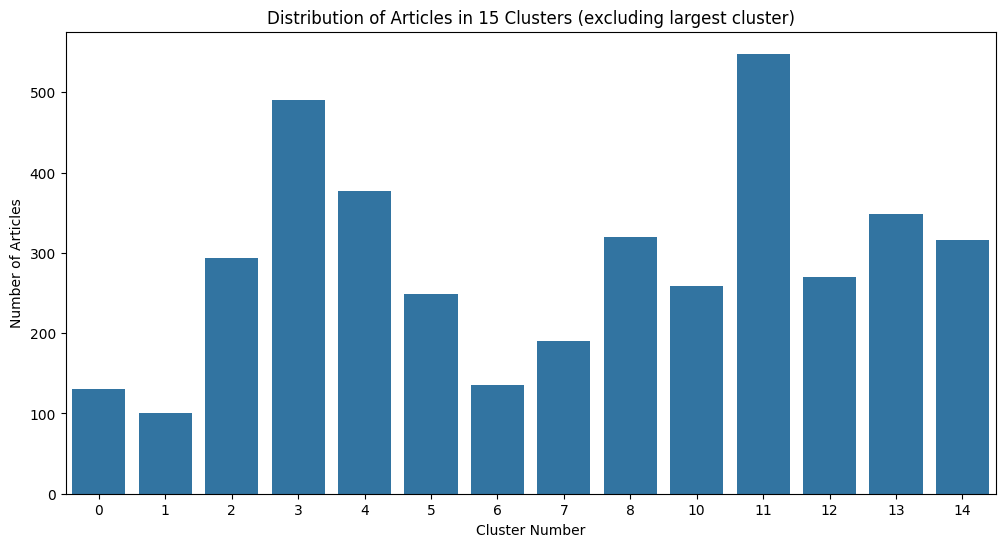

In [64]:
# Convert cluster assignments into a DataFrame for easier counting
cluster_assignment_df = pd.DataFrame({'Article': range(len(cluster_labels)), 'Cluster': cluster_labels})

# Count the number of articles per cluster and remove the largest
cluster_counts = cluster_assignment_df['Cluster'].value_counts().sort_index()
largest_cluster = cluster_counts.idxmax()
cluster_counts = cluster_counts.drop(largest_cluster)

# Create a bar plot showing the distribution of articles per cluster excluding the largest
plt.figure(figsize=(12, 6))
sns.barplot(x=cluster_counts.index, y=cluster_counts.values)
plt.title(f'Distribution of Articles in {num_clusters} Clusters (excluding largest cluster)')
plt.xlabel('Cluster Number')
plt.ylabel('Number of Articles')
plt.show()

###Without the most frequent classer the distribution of topics looks much more the same and with a wider variety



---



In [65]:
# Reduce dimensionality with t-SNE
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
tsne_results = tsne.fit_transform(tfidf_matrix.toarray())  # may need to use dense array


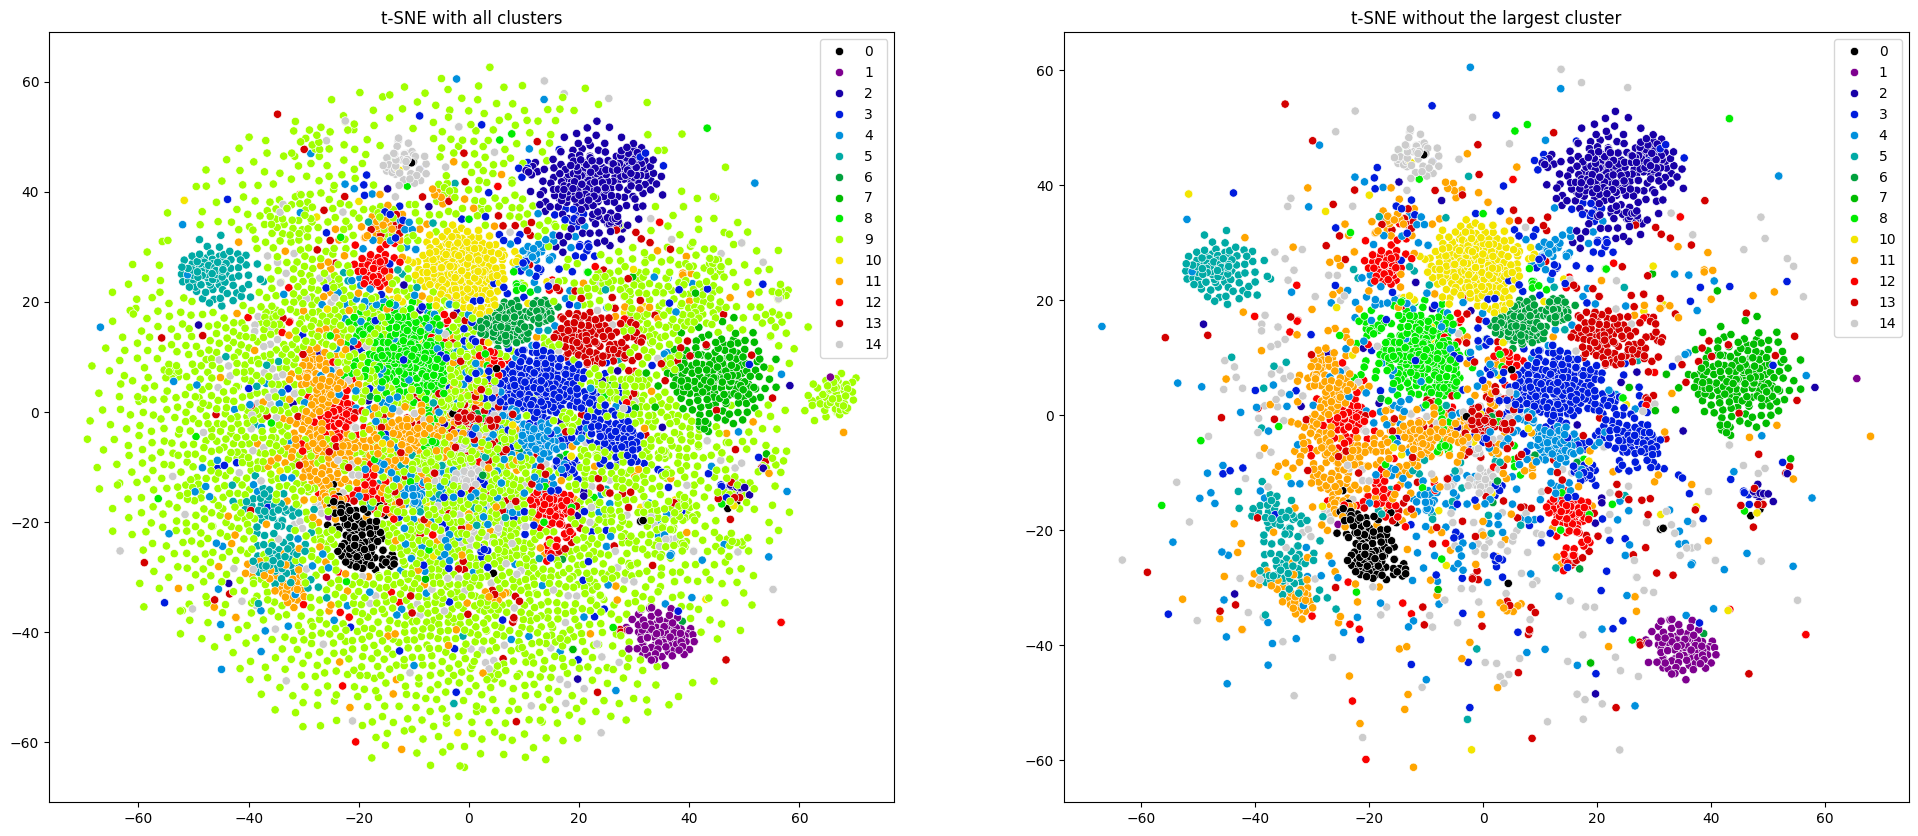

In [66]:
# # Reduce dimensionality with t-SNE
# tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
# tsne_results = tsne.fit_transform(tfidf_matrix.toarray())  # may need to use dense array

# Plot t-SNE with all clusters
plt.figure(figsize=(24, 10))

plt.subplot(1, 2, 1)
sns.scatterplot(x=tsne_results[:, 0], y=tsne_results[:, 1], hue=cluster_labels, palette='nipy_spectral', legend='full')
plt.title('t-SNE with all clusters')

# Remove the largest cluster for the second plot
largest_cluster = np.argmax(np.bincount(cluster_labels))
reduced_labels = np.delete(cluster_labels, np.where(cluster_labels == largest_cluster))
reduced_tsne_results = np.delete(tsne_results, np.where(cluster_labels == largest_cluster), axis=0)

plt.subplot(1, 2, 2)
sns.scatterplot(x=reduced_tsne_results[:, 0], y=reduced_tsne_results[:, 1], hue=reduced_labels, palette='nipy_spectral', legend='full')
plt.title('t-SNE without the largest cluster')

plt.show()

### When examining the difference in the narrowness of the T-SNE of the data, we see how much influence the most common classer has and how much it makes the classification difficult at first.
### We tried to see what the impact would be in terms of the quality of the classification and the different clusters later in the process.


---



#Agglomerative Clustering

In [67]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

# Function to perform Agglomerative clustering and print top terms for each cluster
def agglomerative_clustering_and_top_terms(tfidf_matrix, num_clusters=8, n_terms=10):
    # Perform Agglomerative clustering
    agglomerative = AgglomerativeClustering(n_clusters=num_clusters)
    cluster_labels = agglomerative.fit_predict(tfidf_matrix.toarray()) # Convert to dense if needed

    # Print silhouette score for the clustering
    silhouette_avg = silhouette_score(tfidf_matrix.toarray(), cluster_labels)
    print(f"Silhouette Score for Agglomerative Clustering with {num_clusters} clusters: {silhouette_avg}")

    # There's no direct way of getting the centroid for Agglomerative Clustering,
    # so instead, we print the top terms for a few sample points from each cluster.
    print("Sample terms per cluster (not centroids):")
    for i in range(num_clusters):
        print(f"Cluster {i}: ", end='')
        sample_indices = np.where(cluster_labels == i)[0]
        if len(sample_indices) > 0:
            sample_terms = np.array(tfidf_vectorizer.get_feature_names_out())[tfidf_matrix[sample_indices, :].nonzero()[1]]
            unique_terms = np.unique(sample_terms)
            top_terms = unique_terms[:n_terms] if len(unique_terms) >= n_terms else unique_terms
            print(", ".join(top_terms))

# Assuming tfidf_matrix is already defined
agglomerative_clustering_and_top_terms(tfidf_matrix, num_clusters=8)


Silhouette Score for Agglomerative Clustering with 8 clusters: 0.00020048326532176808
Sample terms per cluster (not centroids):
Cluster 0: 00, 00 pm, 024, 05, 05 termin, 0500, 0500 gmt, 10, 10 11, 10 billion
Cluster 1: 10, 10 bipartisan, 100, 100 billion, 105, 105 billion, 106, 106 billion, 11, 11 vote
Cluster 2: 0500, 0500 gmt, 10, 10 hostag, 10 thai, 100, 100 captiv, 100 day, 100 hostag, 100 nyc
Cluster 3: 1475, 1475 million, 20000, 30000, 30000 die, abus, administr, administr approv, advanc, advanc refuge
Cluster 4: 1000, 1000 goldman, 10000, 10000 palestinian, 17, 17 judg, 1948, 1948 genocid, 1948 wake, 2024
Cluster 5: 250, 250 dead, 300, 300 senior, abandon, abandon support, abroad, abroad countri, academ, academ busi
Cluster 6: 100, 100 peopl, 1000, 1000 dead, 10000, 10000 civilian, 106, 106 billion, 16000, 16000 peopl
Cluster 7: 188, 234, 234 188, accus, accus democrat, accus joe_biden, accus tlaib, adamantli, adamantli deni, addit


>### Despite its appearance, when we initially visually presented the points in the vector space, it seemed that **Agglomerative clustering** could provide good results and of good quality, it seems that the mediation of subjects does not work successfully, so we will continue to work with **K-means**.



---



# Examining the K-means classification without the largest classer

In [68]:
# Find the largest cluster
largest_cluster = np.argmax(np.bincount(cluster_labels))

# Create a mask for all records not part of the largest cluster
mask = cluster_labels != largest_cluster

# Apply the mask to the tfidf_matrix to exclude the largest cluster
reduced_tfidf_matrix = tfidf_matrix[mask]


In [69]:
# Retrain K-Means on the reduced dataset
kmeans_reduced = KMeans(n_clusters=num_clusters, max_iter=100, verbose=2, n_init=1)
reduced_cluster_labels = kmeans_reduced.fit_predict(reduced_tfidf_matrix)

# Print the silhouette score for the new clustering
reduced_silhouette_avg = silhouette_score(reduced_tfidf_matrix, reduced_cluster_labels)
print(f"Silhouette Score for K-Means with {num_clusters} clusters (without largest cluster): {reduced_silhouette_avg}")


Initialization complete
Iteration 0, inertia 7610.669839170921.
Iteration 1, inertia 3931.093139517835.
Iteration 2, inertia 3912.0921191996904.
Iteration 3, inertia 3899.382101062902.
Iteration 4, inertia 3895.669031079101.
Iteration 5, inertia 3893.583571357963.
Iteration 6, inertia 3892.6976966310426.
Iteration 7, inertia 3892.4029548130147.
Iteration 8, inertia 3892.2673834546913.
Iteration 9, inertia 3892.134775227055.
Iteration 10, inertia 3892.064874287804.
Iteration 11, inertia 3892.0220510485533.
Iteration 12, inertia 3892.011965196254.
Converged at iteration 12: strict convergence.
Silhouette Score for K-Means with 15 clusters (without largest cluster): 0.009199702345214517


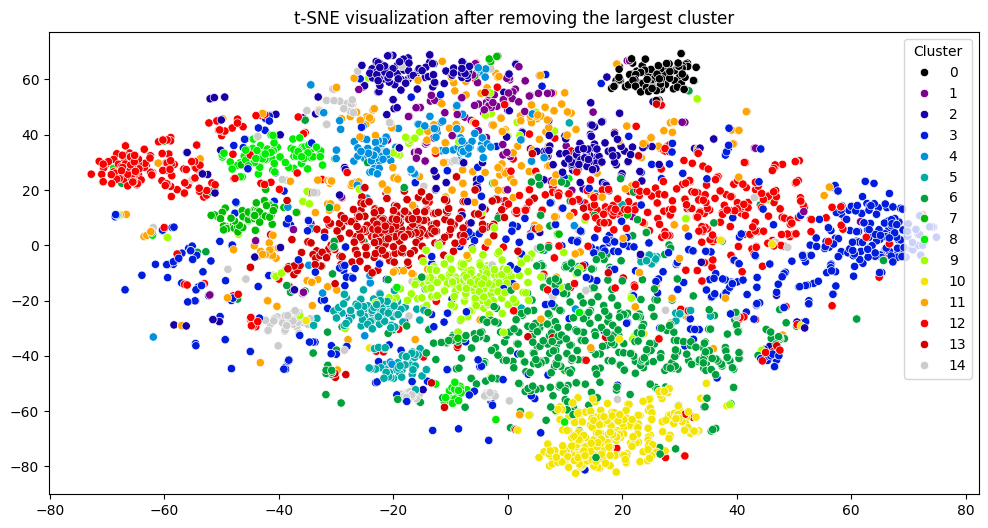

In [70]:
# Run t-SNE on the reduced dataset
tsne_reduced = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
tsne_results_reduced = tsne_reduced.fit_transform(reduced_tfidf_matrix.toarray())

# Plot t-SNE for the reduced dataset
plt.figure(figsize=(12, 6))
sns.scatterplot(x=tsne_results_reduced[:, 0], y=tsne_results_reduced[:, 1], hue=reduced_cluster_labels, palette="nipy_spectral", legend='full')
plt.title('t-SNE visualization after removing the largest cluster')
plt.legend(title='Cluster')
plt.show()


In [71]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.feature_extraction.text import TfidfVectorizer

# Function to perform K-Means clustering and print top terms for each cluster, excluding the largest cluster
def kmeans_clustering_and_top_terms_excluding_largest(tfidf_matrix, num_clusters=6, n_terms=20):
    # Perform K-Means clustering
    kmeans = KMeans(n_clusters=num_clusters, max_iter=100, verbose=2, n_init=1)
    cluster_labels = kmeans.fit_predict(tfidf_matrix)

    # Identify the largest cluster
    largest_cluster = np.argmax(np.bincount(cluster_labels))

    # Filter out the largest cluster
    mask = cluster_labels != largest_cluster
    reduced_data = tfidf_matrix[mask]
    reduced_labels = cluster_labels[mask]

    # Perform K-Means clustering on the reduced dataset
    kmeans_reduced = KMeans(n_clusters=num_clusters - 1, max_iter=100, verbose=2, n_init=1)
    reduced_cluster_labels = kmeans_reduced.fit_predict(reduced_data)

    # Get feature names to print top terms for the reduced clustering
    tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

    # Get top terms for each reduced cluster
    order_centroids_reduced = kmeans_reduced.cluster_centers_.argsort()[:, ::-1]
    print("Top terms per cluster without the largest cluster:")
    for i in range(num_clusters - 1):
        print(f"Cluster {i}: ", end='')
        top_terms = [tfidf_feature_names[ind] for ind in order_centroids_reduced[i, :n_terms]]
        print(", ".join(top_terms))

# Assuming tfidf_matrix is already defined and tfidf_vectorizer is the fitted TfidfVectorizer
kmeans_clustering_and_top_terms_excluding_largest(tfidf_matrix, num_clusters=15)


Initialization complete
Iteration 0, inertia 13452.474588664609.
Iteration 1, inertia 6909.719461561008.
Iteration 2, inertia 6894.527377853382.
Iteration 3, inertia 6883.272775432089.
Iteration 4, inertia 6878.235553595627.
Iteration 5, inertia 6876.272200907617.
Iteration 6, inertia 6875.35310000569.
Iteration 7, inertia 6874.7080388394525.
Iteration 8, inertia 6874.1510141915205.
Iteration 9, inertia 6873.549754796471.
Iteration 10, inertia 6872.828380876568.
Iteration 11, inertia 6872.160291770913.
Iteration 12, inertia 6871.779382285359.
Iteration 13, inertia 6871.222207950095.
Iteration 14, inertia 6870.732677051399.
Iteration 15, inertia 6870.4115651017955.
Iteration 16, inertia 6870.106265990278.
Iteration 17, inertia 6869.926556178481.
Iteration 18, inertia 6869.771627257818.
Iteration 19, inertia 6869.59360134591.
Iteration 20, inertia 6869.423640055325.
Iteration 21, inertia 6869.265185413537.
Iteration 22, inertia 6869.046081412442.
Iteration 23, inertia 6868.709759931215.


### It appears that no significant new themes were discovered after removing the most common cluster.
### This is a good exercise to understand if the classifier improves significantly in understanding the new topics, but we will continue to use the classification results of the original classifier to examine all the data and trends by topic.


---



## Data analysis after creating the classification for subjects

In [73]:
url = 'https://raw.githubusercontent.com/aviya-gmara/News-Classification-Project-/main/clean_dfgnews_cluster_title.csv'

clean_dfgnews_cluster_title = pd.read_csv(url)


In [75]:
clean_dfgnews_cluster_title.head()

Unnamed: 0                                              title  \
0         208  A San Fernando Valley athlete will be represen...   
1         210  Palestinian gunmen reported in Israel as barra...   
2         212   Conflict between Israel and Palestinians in Gaza   
3         214                             On This Day in History   
4         216  US tourist arrested for smashing Roman statues...   

                                         description  \
0  Israel Mateos says frontball isn't typically p...   
1  Palestinian gunmen reported in Israel as barra...   
2   Conflict between Israel and Palestinians in Gaza   
3  On Oct. 6, 1973, Egypt and Syria launched a co...   
4  Israeli police have arrested an American touri...   

                                             content  \
0  Israel Mateos is representing Team USA at this...   
1  Published Oct 07, 2023 12:49AM ET Updated Oct ...   
2  Published Oct 07, 2023 04:09AM ET\n© Reuters. ...   
3  1 of 4 | Israeli soldiers lay flowers at a war...   
4  Israeli police have arrested an American touri...   

                                                 url  \
0  https://abc7.com/israel-mateos-frontball-pan-a...   
1  https://www.investing.com/news/world-news/rock...   
2  https://www.investing.com/news/world-news/conf...   
3  https://www.upi.com/Top_News/2023/10/06/UPI-Al...   
4  https://www.nbcboston.com/news/national-intern...   

                 publishedAt  len_content_article  len_description_article  \
0  2023-10-06 00:11:11+00:00                  266                       97   
1  2023-10-06 04:00:00+00:00                  266                       68   
2  2023-10-06 04:00:00+00:00                  266                       48   
3  2023-10-06 07:00:07+00:00                  266                      175   
4  2023-10-06 08:31:41+00:00                  266                      162   

                                     first_250_words  \
0  israel mateos says frontball isn't typically p...   
1  palestinian gunmen reported in israel as barra...   
2   conflict between israel and palestinians in gaza   
3  on oct. 6, 1973, egypt and syria launched a co...   
4  israeli police have arrested an american touri...   

              sent_word_tokenized_first_250_no_stops  \
0  ['israel', 'mateos', 'says', 'frontball', 'isn...   
1  ['palestinian', 'gunmen', 'reported', 'israel'...   
2     ['conflict', 'israel', 'palestinians', 'gaza']   
3  ['oct', '6', '1973', 'egypt', 'syria', 'launch...   
4  ['israeli', 'police', 'arrested', 'american', ...   

                                             stemmed  \
0  israel mateo say frontbal isnt typic play us p...   
1  palestinian gunmen report israel barrag launch...   
2                   conflict israel palestinian gaza   
3  oct 6 1973 egypt syria launch coordin attack i...   
4  isra polic arrest american tourist israel muse...   

                                     lemmatized_text  \
0          mateo frontbal isnt typic play plan chang   
1            palestinian gunman report barrag launch   
2                               conflict palestinian   
3  oct 6 1973 egypt syria launch coordin attack y...   
4  polic arrest american tourist museum jerusalem...   

                                  clean_text_feature  \
0          mateo frontbal isnt typic play plan chang   
1            palestinian gunman report barrag launch   
2                               conflict palestinian   
3  october 6 1973 egypt syria launch coordin atta...   
4  polic arrest american tourist museum jerusalem...   

                                             Bigrams  initial_cluster  \
0  mateo_frontbal frontbal_isnt isnt_typic typic_...                9   
1  palestinian_gunman gunman_report report_barrag...                9   
2                               conflict_palestinian               14   
3  october_6 6_1973 1973_egypt egypt_syria syria_...                9   
4  polic_arrest arrest_american american_tourist ...            

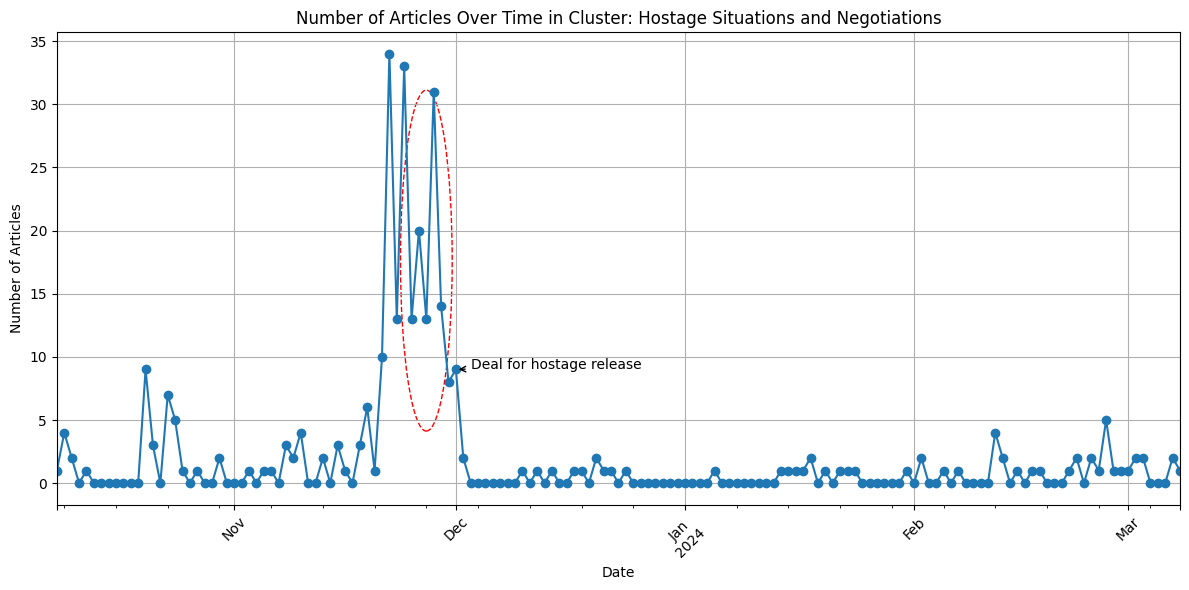

In [79]:
import matplotlib.patches as patches

# Step 1: Filter Articles from Cluster Hostage Situations and Negotiations
# Ensure 'clean_dfgnews_cluster_title' has a 'cluster_title' column where Cluster is labeled as "Hostage Situations and Negotiations"
cluster_Hostage_articles = clean_dfgnews_cluster_title[clean_dfgnews_cluster_title['cluster_title'] == 'Hostage Situations and Negotiations']

# Step 2: Parse the 'publishedAt' Column
# Convert the 'publishedAt' column to datetime format if it's not already
clean_dfgnews_cluster_title['publishedAt'] = pd.to_datetime(clean_dfgnews_cluster_title['publishedAt'], utc=True)  # utc=True ensures timezone-aware datetime

# It's good practice to work on a copy to avoid SettingWithCopyWarning
cluster_Hostage_articles = cluster_Hostage_articles.copy()
cluster_Hostage_articles['publishedAt'] = pd.to_datetime(cluster_Hostage_articles['publishedAt'], utc=True)

# Step 3: Create a Time Series Plot
# Group the Cluster Hostage articles by their publication date. Here, resampling by day ('D')
daily_counts = cluster_Hostage_articles.resample('D', on='publishedAt').size()

plt.figure(figsize=(12, 6))
daily_counts.plot(kind='line', marker='o', linestyle='-')
plt.title('Number of Articles Over Time in Cluster: Hostage Situations and Negotiations')
plt.xlabel('Date')
plt.ylabel('Number of Articles')
plt.grid(True)
plt.xticks(rotation=45)  # Rotate date labels for better readability

# Define the period you want to circle
start_date = pd.to_datetime('2023-11-24', utc=True)
end_date = pd.to_datetime('2023-12-01', utc=True)

# Calculate the middle of the period for the ellipse center and annotation
middle_date = start_date + (end_date - start_date) / 2

# Ellipse parameters
width = (end_date - start_date).days  # Width based on the number of days in the period
height = daily_counts[start_date:end_date].max() - daily_counts[start_date:end_date].min() + 2  # Height based on the range of article counts, +2 for some padding
center = (middle_date, daily_counts[start_date:end_date].mean())  # Center of the ellipse

# Add an ellipse to highlight the period
ellipse = patches.Ellipse(center, width, height, color='red', fill=False, linestyle='--')
plt.gca().add_patch(ellipse)

# Annotate the graph with the event information
event_text = "Deal for hostage release"
plt.annotate(event_text,                      # The text for the annotation
             xy=(end_date, daily_counts.loc[end_date]),  # Point to annotate (end of period, count on that date)
             xytext=(end_date + pd.Timedelta(days=2), daily_counts.loc[end_date]),  # Text position (a few days after end date, count on that date)
             arrowprops=dict(arrowstyle="->", connectionstyle="arc3"),  # Arrow properties
             horizontalalignment='left')  # Horizontal alignment of the text

plt.tight_layout()  # Adjust layout to not cut off labels
plt.show()

##One of the things that interested us was to see how much the news in the US covered the matter of the abductees.
##As you can see throughout the period there is almost no engagement with the issue except for the period when there was a deal to release a hostage `(24/11/23 -- 1/12/23)`

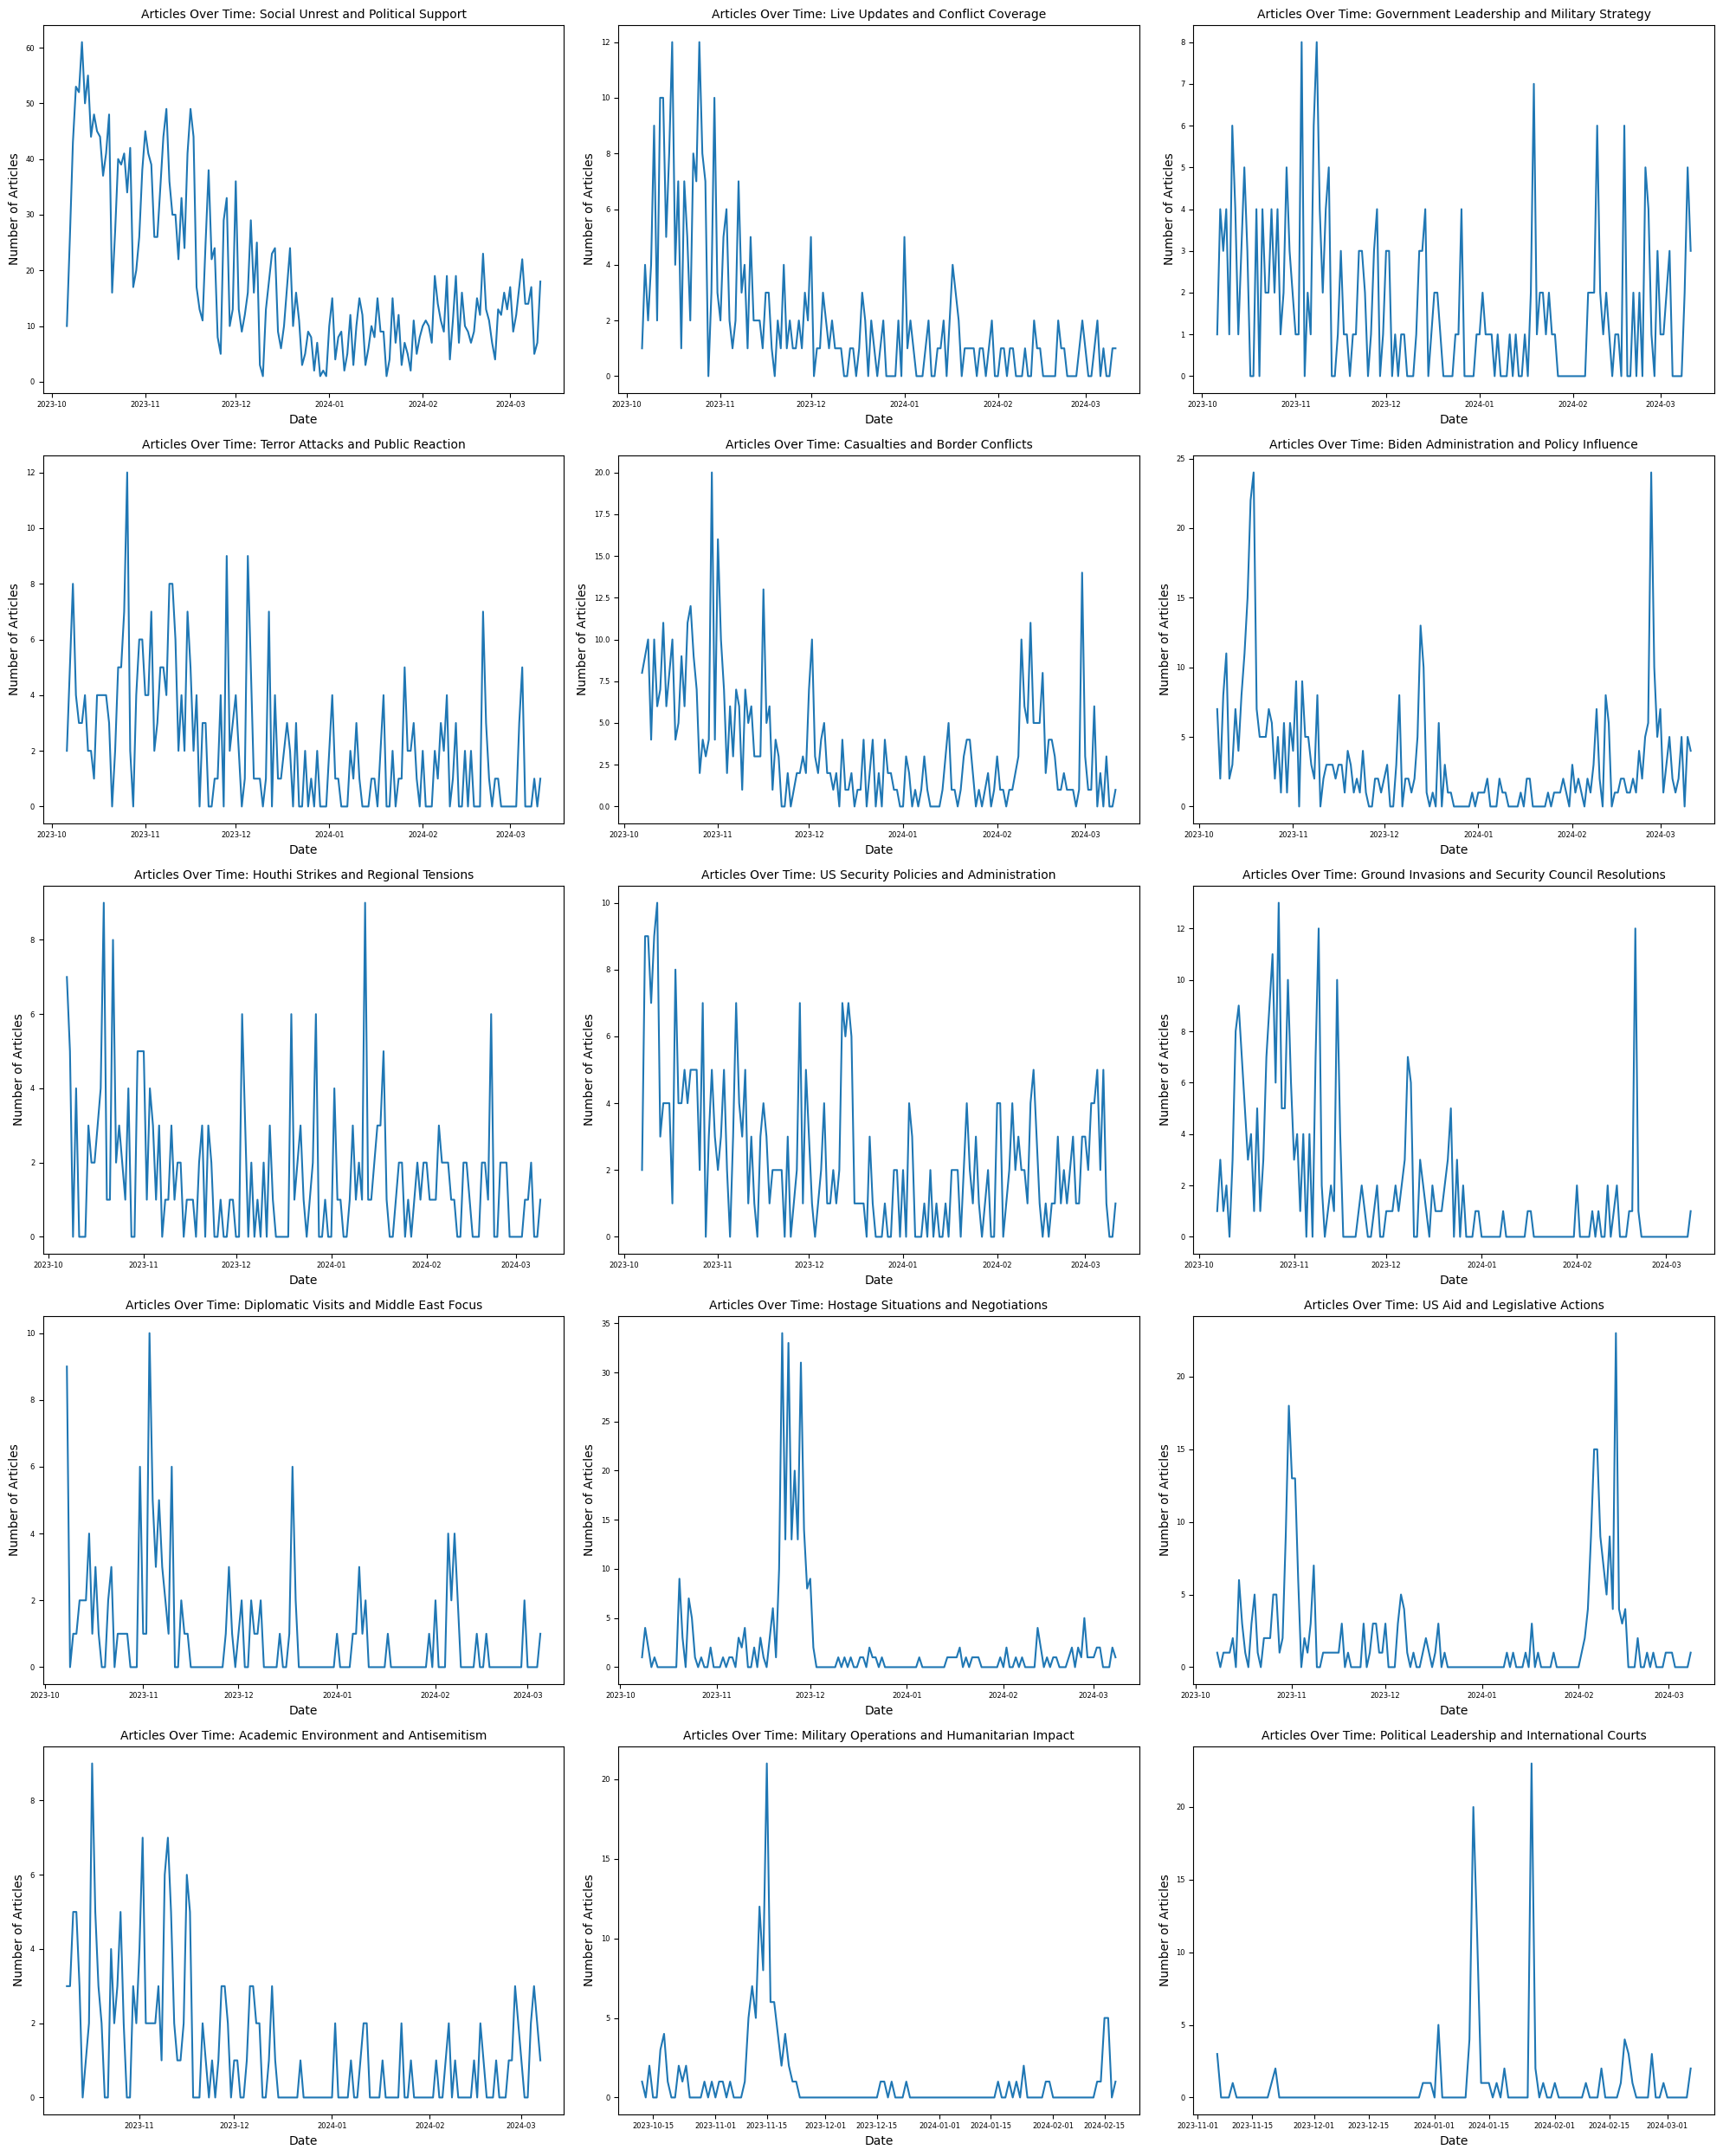

In [102]:
# Number of graphs per row
graphs_per_row = 3

# Total number of unique titles
n_titles = len(clean_dfgnews['cluster_title'].unique())

# Calculate the number of rows needed
n_rows = int(np.ceil(n_titles / graphs_per_row))

# Create a grid of subplots
fig, axs = plt.subplots(n_rows, graphs_per_row, figsize=(20, 5 * n_rows))

# Flatten the array of axes to make iterating easier
axs = axs.flatten()

for i, title in enumerate(clean_dfgnews['cluster_title'].unique()):
    cluster_articles = clean_dfgnews[clean_dfgnews['cluster_title'] == title]
    daily_counts = cluster_articles.resample('D', on='publishedAt').size()

    # Plot on the ith subplot
    axs[i].plot(daily_counts.index, daily_counts.values)
    axs[i].set_title(f'Articles Over Time: {title}', fontsize=10)
    axs[i].set_xlabel('Date', fontsize=10)
    axs[i].set_ylabel('Number of Articles', fontsize=10)
    axs[i].tick_params(labelsize=6)

# Hide any unused subplots if the number of titles isn't a perfect multiple of graphs_per_row
for j in range(i + 1, len(axs)):
    axs[j].axis('off')

plt.tight_layout()
plt.show()


- **Social Unrest and Political Support** seems to be covered relatively often and consistently over time, indicating it's a regular subject in the news.

- **Academic Environment and Antisemitism** is less talked about, with only occasional reporting, suggesting it's not a persistent topic in the news cycle.

- **Terror Attacks and Public Reaction** has significant coverage with notable peaks, likely aligning with specific events that prompt public interest and media reporting.

- **Military Operations and Humanitarian Impact** has an exceptionally high peak followed by a decrease, indicating a major event that was heavily covered, then tapered off.

This shorter analysis captures the overall trends for the most and least consistently covered topics, as well as those with the most pronounced fluctuations.

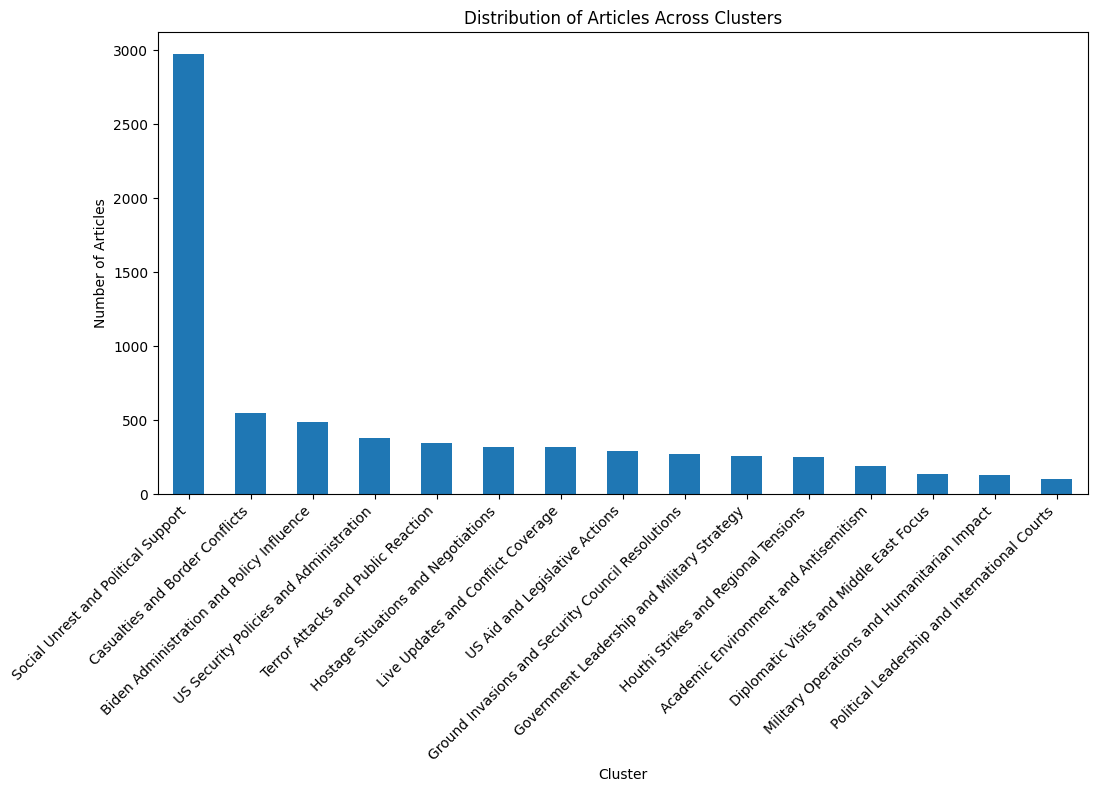

In [84]:
cluster_distribution = clean_dfgnews_cluster_title['cluster_title'].value_counts()

plt.figure(figsize=(12, 6))
cluster_distribution.plot(kind='bar')
plt.title('Distribution of Articles Across Clusters')
plt.xlabel('Cluster')
plt.ylabel('Number of Articles')
plt.xticks(rotation=45, ha='right')
plt.show()


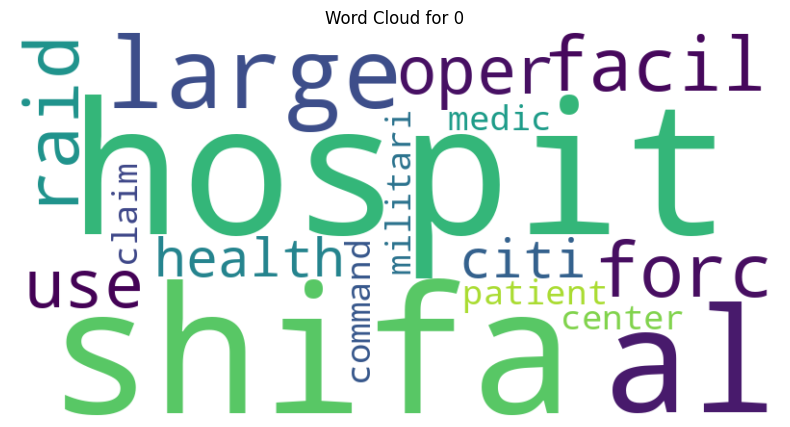

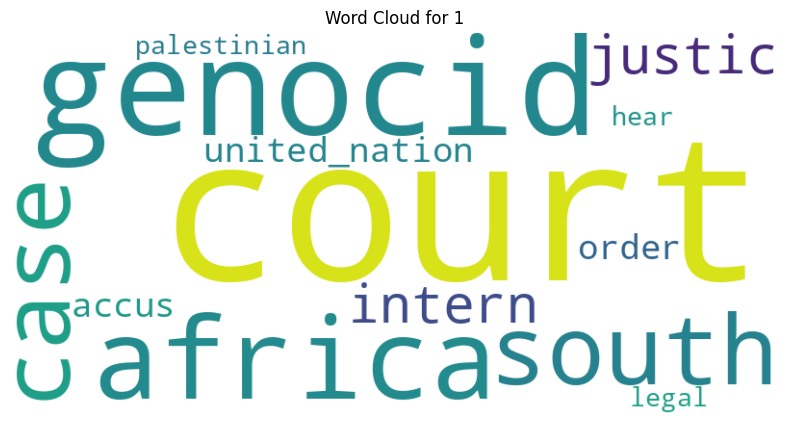

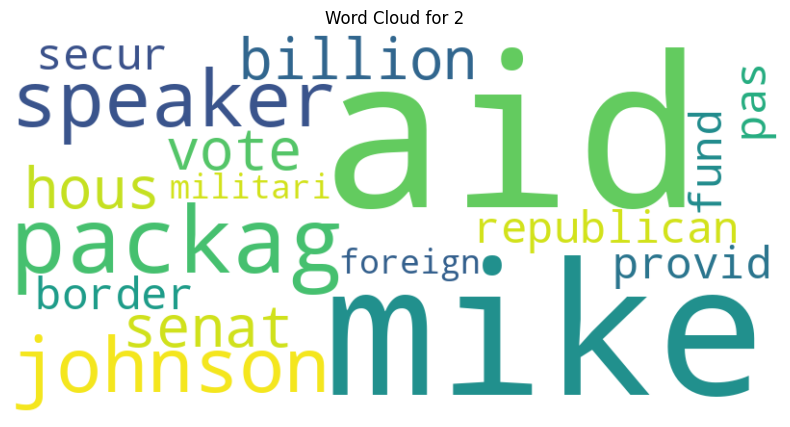

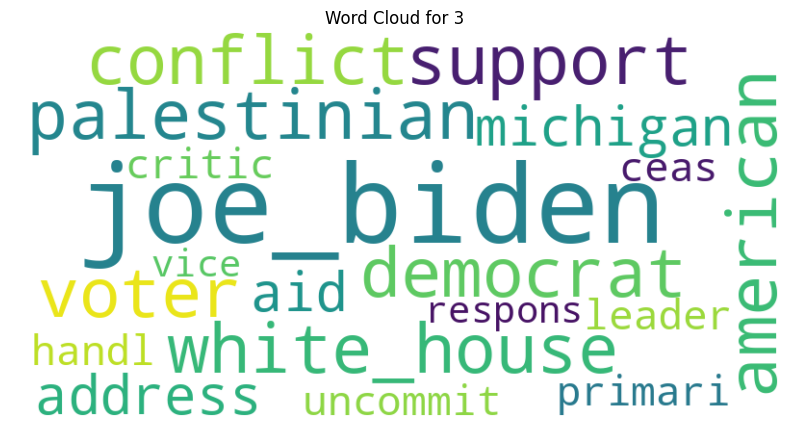

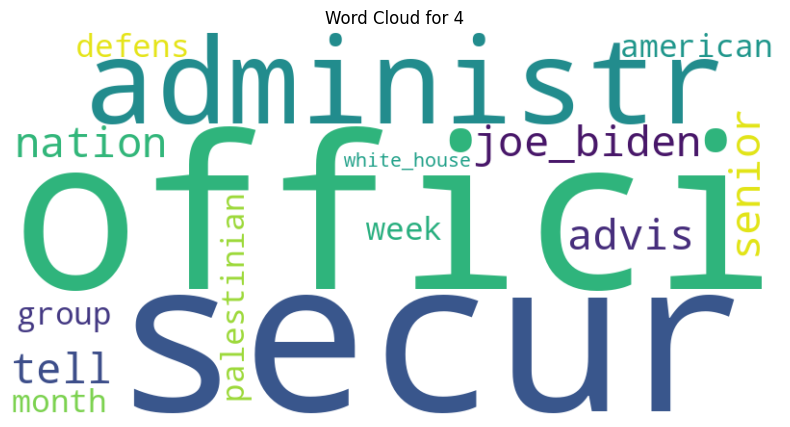

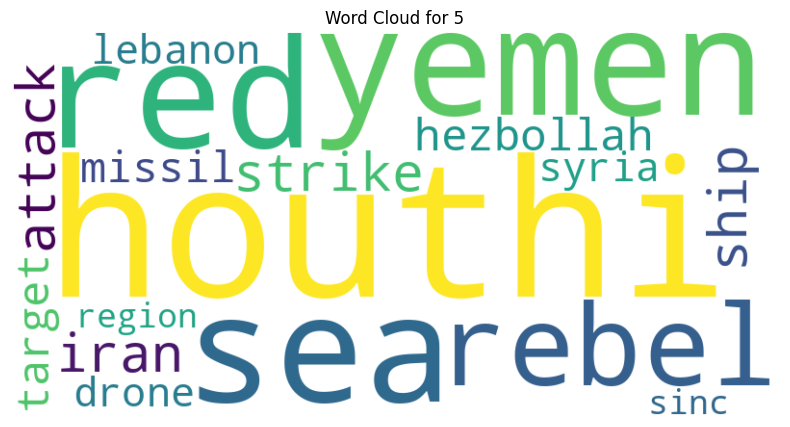

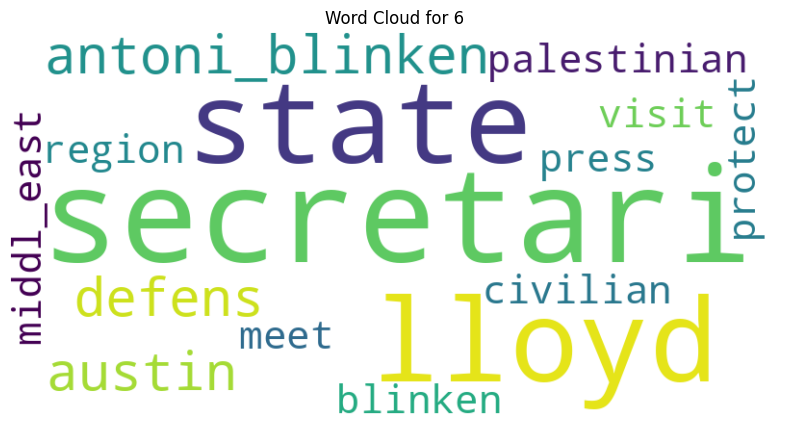

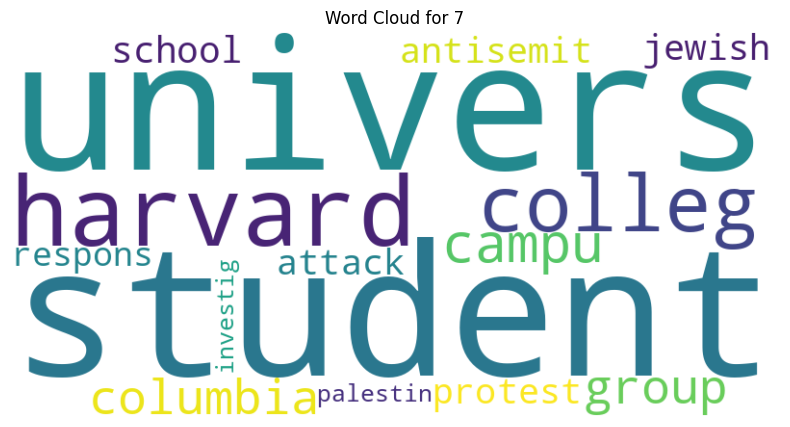

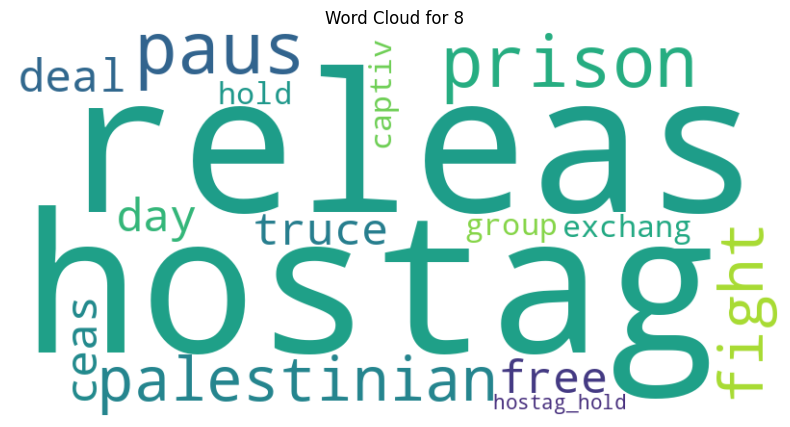

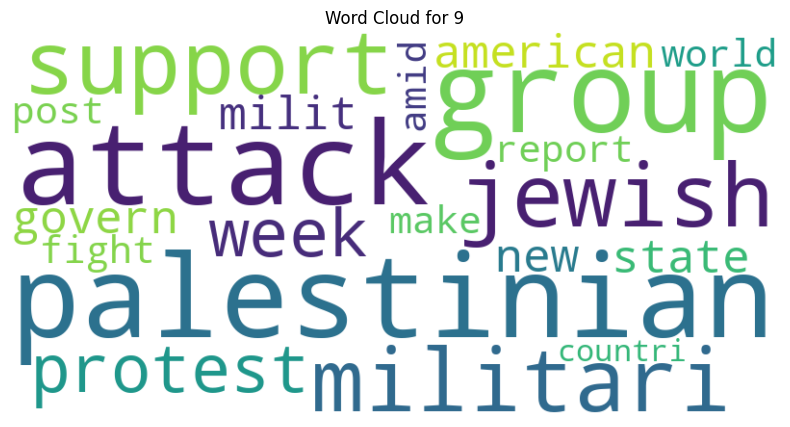

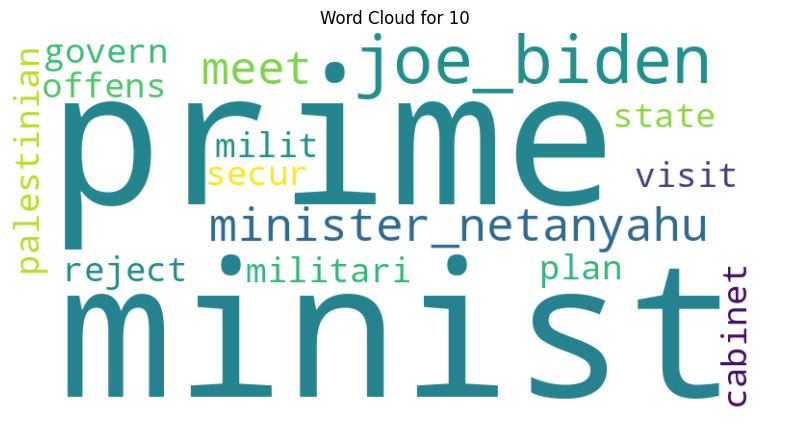

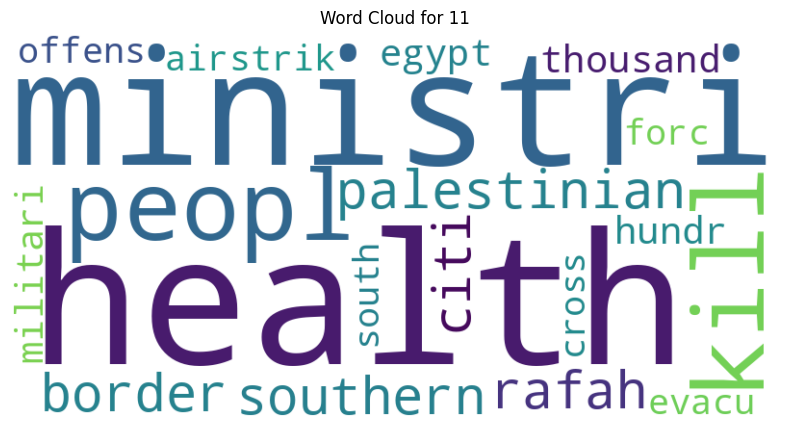

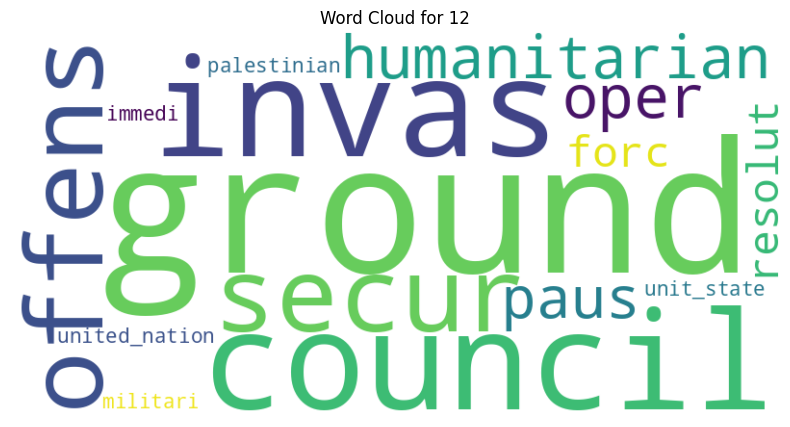

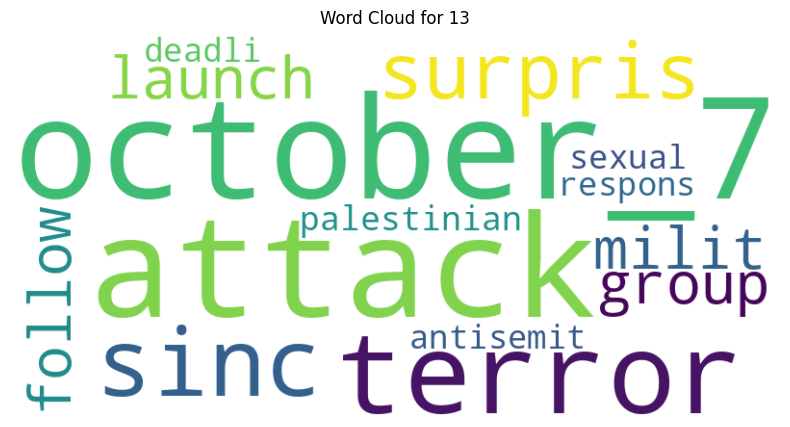

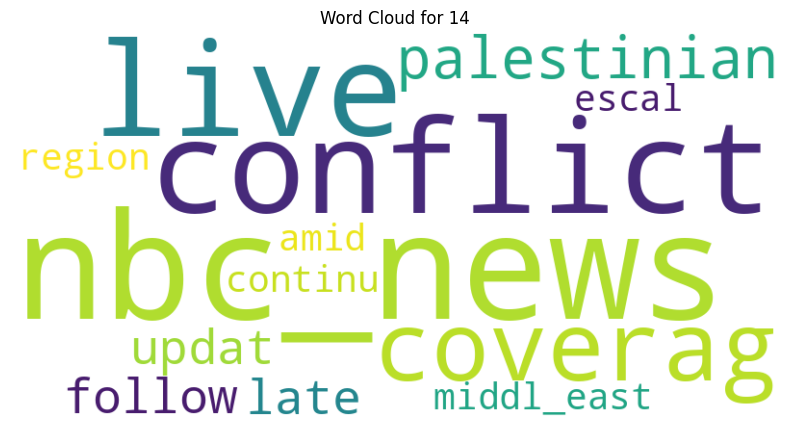

In [85]:
for title, terms in cluster_terms.items():  # Assuming 'cluster_terms' is a dictionary with top terms for each cluster
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(terms))

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for {title}')
    plt.axis('off')
    plt.show()



---


# **Sentence Transformers Semantic**
### We wanted to examine whether too much work on cleaning the data created difficulty in understanding the meaning of the text itself and thus the division into topics and that perhaps through an understanding of the semantics, etc., the data could be divided better and reduce overlap and expand the topics.
### We used the SentenceTransformer we found to check how it looks when it classifies the description of the news.

In [90]:

embedder = SentenceTransformer('all-MiniLM-L6-v2')

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [91]:
corpus_embeddings = embedder.encode(documents_description)

# Normalize the embeddings to unit length
corpus_embeddings = corpus_embeddings /  np.linalg.norm(corpus_embeddings, axis=1, keepdims=True)

In [92]:
# corpus_embeddings[0]

In [93]:

clustering_model = KMeans(n_clusters=10)
clustering_model.fit(corpus_embeddings)
cluster_assignment = clustering_model.labels_
print(cluster_assignment)

[6 0 9 ... 2 7 8]


In [94]:
clustered_sentences = {}
for sentence_id, cluster_id in enumerate(cluster_assignment):

    if cluster_id not in clustered_sentences:
        clustered_sentences[cluster_id] = []

    if len(clustered_sentences[cluster_id]) < 10:
        clustered_sentences[cluster_id].append(documents_description[sentence_id])

for cluster_id, sentences in clustered_sentences.items():
    print(f"Cluster {cluster_id}:")
    for sentence in sentences:
        print(sentence)
    print("")


Cluster 6:
Israel Mateos says frontball isn't typically played in the U.S., but he has plans to change that.
At Symphony Hall Friday, artistic director Jonathan Cohen had an orchestra of 35 and a chorus of 34. He conducted from the harpsichord, bouncing on his feet when standing, bouncing even when seated.
The former vice president called out Donald Trump, Ron DeSantis and Vivek Ramaswamy by name.
Brazil's Foreign Ministry said on Saturday it would convene an emergency meeting of the United Nations Security Council following the biggest attack on Israel in years.
House lawmakers are scrambling to determine whether acting Speaker Patrick McHenry can participate in a so-called Gang of Eight intelligence briefing on the unfolding crisis in Israel, a source familiar with the active discussions told CNN.
Brandeis President Ron Liebowitz said the university was “deeply saddened” to learn that Ilan Troen, a Brandeis professor emeritus living in Israel, had lost his daughter and son-in-law.
“W

**Cluster 0:** Involves Palestinian militant actions, with emphasis on rocket barrages and incursions into Israel, highlighting surprise attacks and their impact.

**Cluster 1:** Focuses on international legal and political responses, including court actions, genocide accusations, and reactions from global entities like the UN.

**Cluster 2:** Centers on U.S. legislative actions, aid packages, and political discussions, reflecting on internal and external policy decisions.

**Cluster 3:** Covers Biden's administration's stance and actions in response to the conflict, illustrating U.S. political dynamics and policy implications.

**Cluster 4:** Discusses U.S. security strategies, administration's official statements, and national security policies in the context of the conflict.

**Cluster 5:** Highlights Houthi and regional tensions, including strikes, maritime security concerns, and the broader implications of regional conflicts.

**Cluster 6:** Describes diplomatic engagements and initiatives, focusing on high-level visits and statements by U.S. officials like Blinken and Austin.

**Cluster 7:** Examines the academic and antisemitism discourse, particularly in university settings, indicating social and educational implications.

**Cluster 8:** Details negotiation efforts and hostage situations, showcasing attempts to resolve conflicts through diplomatic channels.

**Cluster 9:** Reflects on social unrest and support for political groups, illustrating societal reactions and the role of governance in conflict resolution.

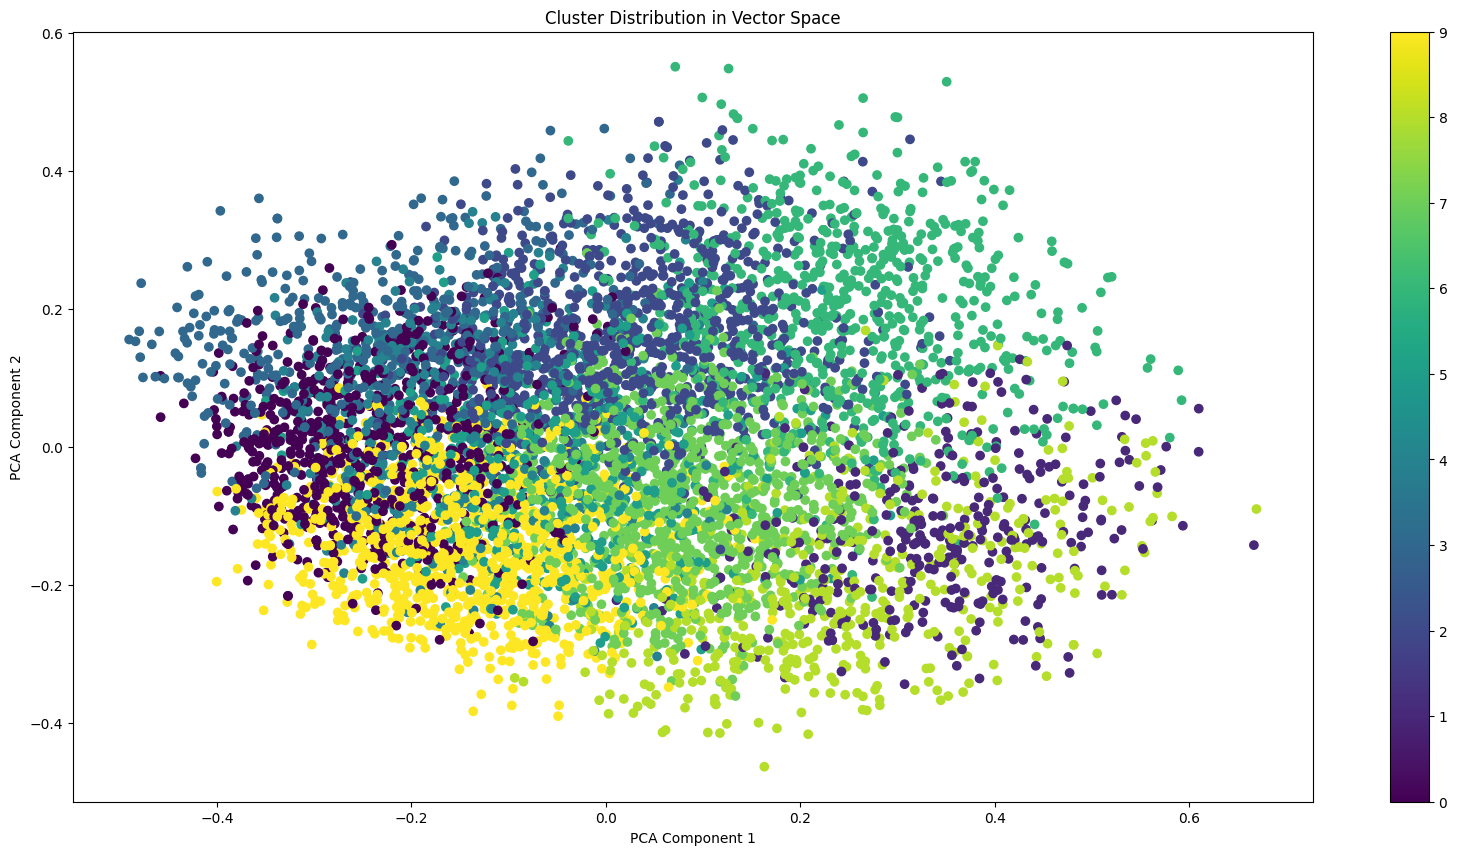

In [98]:

# Assuming 'corpus_embeddings' is your embeddings matrix and 'cluster_assignment' contains the cluster labels

# Reduce the dimensionality to 2 components for visualization
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(corpus_embeddings)

# Convert cluster assignments into a list if it's not already
cluster_assignment_list = list(cluster_assignment)

# Create a scatter plot
plt.figure(figsize=(20, 10))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=cluster_assignment_list, cmap='viridis')
plt.title('Cluster Distribution in Vector Space')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar()
plt.show()


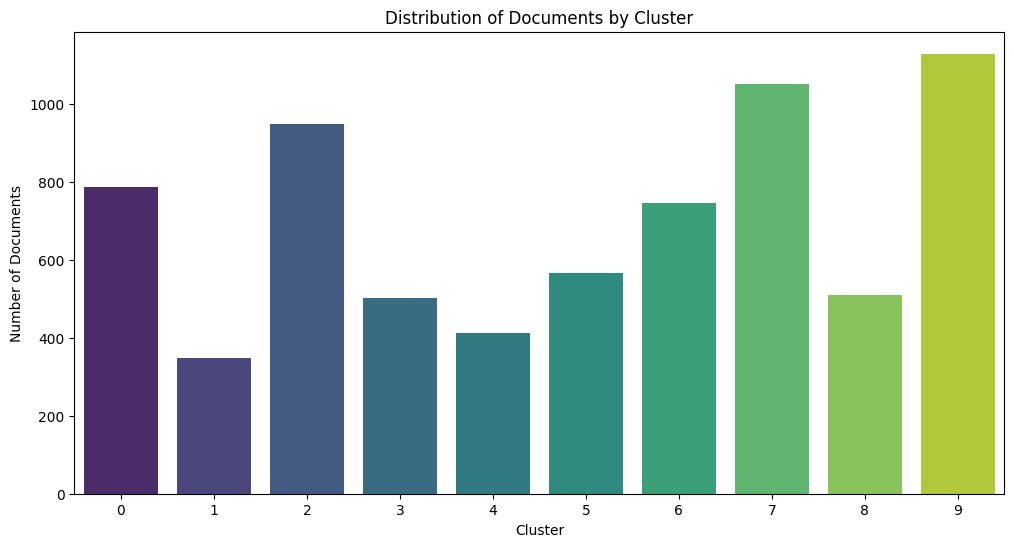

In [99]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Assuming 'cluster_assignment' is a list of cluster labels for your documents
cluster_counter = Counter(cluster_assignment)

# Convert to DataFrame for easier plotting
cluster_df = pd.DataFrame(cluster_counter.items(), columns=['Cluster', 'Count']).sort_values('Cluster')

# Generate bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x='Cluster', y='Count', data=cluster_df, palette="viridis")
plt.title('Distribution of Documents by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Number of Documents')
plt.show()


> ## It can be seen that here too there is a lot of overlap between the topics and difficult separation, which proves that it is possible to understand the general topics between the topics but that it will be difficult to test the quality of the model.


> ## On the other hand, the division into topics is more balanced and it may be useful to use this model to understand the topics more deeply.


